## Daily Backtesting Development

These steps cover the development of the Zero-Lag MACD for backtesting enhanced trading strategies in trading scenarios using the integration of machine learning models and ensemble learning approaches on a daily interval.

Data Preparation & Utilities:
- This cell defines utility functions for fetching stock data, preprocessing (splitting, scaling), converting to Darts TimeSeries, inverse transforming predictions, calculating detailed regression metrics, and visualizing actual vs. predicted stock prices for model evaluation.

Purpose:
- These functions streamline the workflow for time series forecasting and model performance analysis in the notebook.

Step 1: Run following cells for the data preparation steps.

In [1]:
from darts import TimeSeries
from darts.metrics import mape, rmse, mse, mae, r2_score, coefficient_of_variation
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def fetch_stock_data(ticker, start_date, end_date, interval):
    """Fetch and prepare stock data"""
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    
    freq_map = {"15m": "15T", "30m": "30T", "1h": "h", "1d": "B"}
    df.index = pd.DatetimeIndex(df.index)
    df = df.asfreq(freq_map.get(interval, "B"))
    return df.ffill()

def prepare_data(df, train_size=0.8):
    """Prepare and split data into train and test sets"""
    target_series = df[['Close']]
    covariates = df[['Open', 'High', 'Low', 'Volume']]
    
    split_idx = int(len(df) * train_size)
    return {
        'train_target': target_series[:split_idx],
        'test_target': target_series[split_idx:],
        'train_covariates': covariates[:split_idx],
        'test_covariates': covariates[split_idx:]
    }

def scale_data(data_dict):
    """Scale the data using MinMaxScaler"""
    target_scaler = MinMaxScaler()
    covariate_scaler = MinMaxScaler()
    
    scaled_data = {}
    for key in ['train_target', 'test_target']:
        scaled_data[key] = pd.DataFrame(
            target_scaler.fit_transform(data_dict[key]) if 'train' in key 
            else target_scaler.transform(data_dict[key]),
            columns=['Close'],
            index=data_dict[key].index
        )
    
    for key in ['train_covariates', 'test_covariates']:
        scaled_data[key] = pd.DataFrame(
            covariate_scaler.fit_transform(data_dict[key]) if 'train' in key 
            else covariate_scaler.transform(data_dict[key]),
            columns=['Open', 'High', 'Low', 'Volume'],
            index=data_dict[key].index
        )
    
    return scaled_data, target_scaler

def create_time_series(scaled_data, interval):
    """Convert scaled data to TimeSeries objects"""
    freq_map = {"15m": "15T", "30m": "30T", "1h": "h", "1d": "B"}
    freq = freq_map.get(interval, "B")
    
    return {
        'train_y': TimeSeries.from_dataframe(scaled_data['train_target'], freq=freq),
        'test_y': TimeSeries.from_dataframe(scaled_data['test_target'], freq=freq),
        'train_x': TimeSeries.from_dataframe(scaled_data['train_covariates'], freq=freq),
        'test_x': TimeSeries.from_dataframe(scaled_data['test_covariates'], freq=freq)
    }

def inverse_transform_series(scaled_series, scaler):
    """Inverse transform scaled data"""
    scaled_values = scaled_series.values().flatten()
    inverse_transformed = scaler.inverse_transform(scaled_values.reshape(-1, 1)).flatten()
    return TimeSeries.from_times_and_values(
        times=scaled_series.time_index,
        values=inverse_transformed
    )

def print_detailed_metrics(actual, predicted, period="Training"):
    """
    Calculate and print detailed metrics for model evaluation
    """
    print(f"\n{period} Period Performance:")
    print("-" * 30)
    
    # Calculate basic metrics
    rmse_val = rmse(actual, predicted)
    mse_val = mse(actual, predicted)
    mae_val = mae(actual, predicted)
    mape_val = mape(actual, predicted)
    r2_val = r2_score(actual, predicted)
    cv_score = coefficient_of_variation(actual, predicted)
    
    # Print metrics
    print(f"RMSE: ${rmse_val:.4f}")
    print(f"MSE: ${mse_val:.4f}")
    print(f"MAE: ${mae_val:.4f}")
    print(f"MAPE: {mape_val:.2f}%")
    print(f"R² Score: {r2_val:.4f}")
    print(f"Coefficient of Variation: {cv_score:.4f}")
    
    # Calculate prediction statistics
    pred_values = predicted.values().flatten()
    print(f"\nPrediction Statistics:")
    print("-" * 30)
    print(f"Mean: ${np.mean(pred_values):.4f}")
    print(f"Std Dev: ${np.std(pred_values):.4f}")
    print(f"Min: ${np.min(pred_values):.4f}")
    print(f"Max: ${np.max(pred_values):.4f}")

def visualize_results(train_y, test_y, train_pred, test_pred, future_pred, ticker, interval, model_name):
    """Create and display visualization"""
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_y.time_index, y=train_y.values().flatten(),
                            name='Training Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=train_pred.time_index, y=train_pred.values().flatten(),
                            name='Training Predicted', line=dict(color='lightblue', dash='dash')))
    fig.add_trace(go.Scatter(x=test_y.time_index, y=test_y.values().flatten(),
                            name='Test Actual', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=test_pred.time_index, y=test_pred.values().flatten(),
                            name='Test Predicted', line=dict(color='orange', dash='dash')))
    fig.add_trace(go.Scatter(x=future_pred.time_index, y=future_pred.values().flatten(),
                            name='Future Predictions', line=dict(color='green', dash='dash')))
    
    fig.add_vline(x=train_y.time_index[-1], line_dash="dash", line_color="gray")
    
    fig.update_layout(
        title=f'{ticker} Stock Price {model_name} Prediction ({interval} interval)',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig.show()

RNN/LSTM/GRU Training Utilities:
- This cell provides helper functions for deep learning model training, including PyTorch Lightning callbacks for tracking training/validation loss, plotting loss and performance curves, preparing and scaling data, creating validation splits, and visualizing actual vs. predicted prices for RNN-based models.

Purpose:
- These utilities streamline model training, monitoring, and evaluation for time series forecasting tasks.

Step 2: Run the following cells for deep learning model training

In [2]:
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
import warnings
import logging
import pytorch_lightning as pl
import torch

# Suppress specific warning about output_chunk_length
warnings.filterwarnings("ignore", message="ignoring user defined `output_chunk_length`")

# Reduce PyTorch Lightning verbosity
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# Disable model summary in trainers
pl.trainer.connectors.logger_connector.logger_connector._is_on_colab = lambda: True

# Create a callback to track metrics
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [],
            'val_loss': []
        }
    
    def on_train_epoch_end(self, trainer, pl_module):
        self.metrics['train_loss'].append(trainer.callback_metrics.get('train_loss', 0))
        self.metrics['val_loss'].append(trainer.callback_metrics.get('val_loss', 0))

def plot_training_metrics(metrics_callback, model_name="LSTM"):
    """Plot loss curves during training"""
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics_callback.metrics['train_loss'], label='Training Loss', color='blue')
    plt.plot(metrics_callback.metrics['val_loss'], label='Validation Loss', color='red')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Plot learning curve (inverse of loss)
    plt.subplot(1, 2, 2)
    train_accuracy = [1/(1+x) for x in metrics_callback.metrics['train_loss']]
    val_accuracy = [1/(1+x) for x in metrics_callback.metrics['val_loss']]
    plt.plot(train_accuracy, label='Training Performance', color='blue')
    plt.plot(val_accuracy, label='Validation Performance', color='red')
    plt.title(f'{model_name} Model Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Performance Score')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def fetch_stock_data(ticker, start_date, end_date, interval):
    """Fetch and prepare stock data"""
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    
    freq_map = {"15m": "15T", "30m": "30T", "1h": "H", "1d": "B"}
    df.index = pd.DatetimeIndex(df.index)
    df = df.asfreq(freq_map.get(interval, "B"))
    return df.fillna(method='ffill')

def prepare_data(df, train_size=0.8):
    """Prepare and split data into train and test sets"""
    target_series = df[['Close']]
    covariates = df[['Open', 'High', 'Low', 'Volume']]
    
    split_idx = int(len(df) * train_size)
    return {
        'train_target': target_series[:split_idx],
        'test_target': target_series[split_idx:],
        'train_covariates': covariates[:split_idx],
        'test_covariates': covariates[split_idx:]
    }

def scale_data(data_dict):
    """Scale the data using MinMaxScaler"""
    target_scaler = MinMaxScaler()
    covariate_scaler = MinMaxScaler()
    
    scaled_data = {}
    for key in ['train_target', 'test_target']:
        scaled_data[key] = pd.DataFrame(
            target_scaler.fit_transform(data_dict[key]) if 'train' in key 
            else target_scaler.transform(data_dict[key]),
            columns=['Close'],
            index=data_dict[key].index
        )
    
    for key in ['train_covariates', 'test_covariates']:
        scaled_data[key] = pd.DataFrame(
            covariate_scaler.fit_transform(data_dict[key]) if 'train' in key 
            else covariate_scaler.transform(data_dict[key]),
            columns=['Open', 'High', 'Low', 'Volume'],
            index=data_dict[key].index
        )
    
    return scaled_data, target_scaler

def create_time_series(scaled_data, interval):
    """Convert scaled data to TimeSeries objects"""
    freq_map = {"15m": "15T", "30m": "30T", "1h": "H", "1d": "B"}
    freq = freq_map.get(interval, "B")
    
    return {
        'train_y': TimeSeries.from_dataframe(scaled_data['train_target'], freq=freq),
        'test_y': TimeSeries.from_dataframe(scaled_data['test_target'], freq=freq),
        'train_x': TimeSeries.from_dataframe(scaled_data['train_covariates'], freq=freq),
        'test_x': TimeSeries.from_dataframe(scaled_data['test_covariates'], freq=freq)
    }

def create_validation_split(train_y, train_x, val_split=0.2):
    """
    Split training data to create validation data
    """
    # Calculate split point
    split_idx = int(len(train_y) * (1 - val_split))
    
    # Split the data
    train_y_new = train_y[:split_idx]
    val_y = train_y[split_idx:]
    train_x_new = train_x[:split_idx]
    val_x = train_x[split_idx:]
    
    return {
        'train_y': train_y_new,
        'val_y': val_y,
        'train_x': train_x_new,
        'val_x': val_x
    }

def inverse_transform_series(scaled_series, scaler):
    """Inverse transform scaled data"""
    scaled_values = scaled_series.values().flatten()
    inverse_transformed = scaler.inverse_transform(scaled_values.reshape(-1, 1)).flatten()
    return TimeSeries.from_times_and_values(
        times=scaled_series.time_index,
        values=inverse_transformed
    )

def print_detailed_rnn_metrics(actual, predicted, period="Training"):
    """
    Calculate and print detailed metrics for model evaluation
    """
    print(f"\n{period} Period Performance:")
    print("-" * 30)
    
    # Calculate basic metrics
    rmse_val = rmse(actual, predicted)
    mse_val = mse(actual, predicted)
    mae_val = mae(actual, predicted)
    mape_val = mape(actual, predicted)
    r2_val = r2_score(actual, predicted)
    cv_score = coefficient_of_variation(actual, predicted)
    
    # Print metrics
    print(f"RMSE: ${rmse_val:.4f}")
    print(f"MSE: ${mse_val:.4f}")
    print(f"MAE: ${mae_val:.4f}")
    print(f"MAPE: {mape_val:.2f}%")
    print(f"R² Score: {r2_val:.4f}")
    print(f"Coefficient of Variation: {cv_score:.4f}")
    
    # Calculate prediction statistics
    pred_values = predicted.values().flatten()
    print(f"\nPrediction Statistics:")
    print("-" * 30)
    print(f"Mean: ${np.mean(pred_values):.4f}")
    print(f"Std Dev: ${np.std(pred_values):.4f}")
    print(f"Min: ${np.min(pred_values):.4f}")
    print(f"Max: ${np.max(pred_values):.4f}")

def rnn_visualize_results(train_y, test_y, train_pred, test_pred, ticker, interval):
    """Create and display visualization"""
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=train_y.time_index, y=train_y.values().flatten(),
                            name='Training Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=train_pred.time_index, y=train_pred.values().flatten(),
                            name='Training Predicted', line=dict(color='lightblue', dash='dash')))
    fig.add_trace(go.Scatter(x=test_y.time_index, y=test_y.values().flatten(),
                            name='Test Actual', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=test_pred.time_index, y=test_pred.values().flatten(),
                            name='Test Predicted', line=dict(color='orange', dash='dash')))
    
    fig.add_vline(x=train_y.time_index[-1], line_dash="dash", line_color="gray")
    
    fig.update_layout(
        title=f'{ticker} Stock Price Prediction Analysis ({interval} interval)',
        xaxis_title='Date',
        yaxis_title='Price ($)',
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig.show()

### Individual Model Selection

Individual Model Selection: This section allows you to select and train individual machine learning models for stock price prediction before applying them to trading strategies. You can choose from：
1. Linear Regression
2. Random Forest
3. XGBoost 
4. LSTM 
5. GRU

Each model is optimized using Optuna hyperparameter tuning to find the best configuration for stock prediction accuracy. Once trained, these models generate price predictions that are used to validate Zero-Lag MACD trading signals, ensuring trades are executed only when the predicted next-day price movement aligns with the predefined trading direction. This approach combines technical analysis signals with machine learning predictions to improve trading decision quality and reduce false signals. Make sure to switch to the selected stock name, and set the appropriate start date, end date, and data interval to ensure accurate model training and evaluation.

Step 3: Run the following cells, but only for the specific machine learning model that you choose to test the trading strategies with Zero-Lag MACD.

If you want to backtest the trading strategy with linear regression, then only run the following **Linear Regression** model pipeline cells

In [ ]:
import optuna
from darts.models import LinearRegressionModel
from darts.metrics import rmse

def lr_train_model(ts_data, n_trials=20):  # Reduced trials for simple model
    """Train Linear Regression using Optuna - OPTIMIZED for stock prediction"""

    def objective(trial):
        lags = trial.suggest_categorical('lags', [24]) 
        lags_cov = trial.suggest_categorical('lags_past_covariates', [24])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])  
        positive = trial.suggest_categorical('positive', [False, True])

        model = LinearRegressionModel(
            lags=lags,
            lags_past_covariates=lags_cov,
            output_chunk_length=1,
            fit_intercept=fit_intercept,
            positive=positive,
            random_state=42
        )

        model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

        # Predict on validation part of train data
        preds = model.historical_forecasts(
            ts_data['train_y'],
            past_covariates=ts_data['train_x'],
            start=lags,
            forecast_horizon=1,
            stride=1,
            retrain=False,
            verbose=False
        )

        return rmse(ts_data['train_y'][lags:], preds)

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params

    # Train the best model
    best_model = LinearRegressionModel(
        lags=best_params['lags'],
        lags_past_covariates=best_params['lags_past_covariates'],
        output_chunk_length=1,
        fit_intercept=True,
        positive=False,
        random_state=42
    )
    best_model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

    print(f"\n📈 Linear Regression - Stock-Optimized Parameters (Optuna):")
    print("-" * 50)
    print(best_params)
    print(f"\nBest RMSE: {study.best_value:.4f}")

    return best_model, best_params, study.best_value

def lr_generate_predictions(model, ts_data, best_params):
    """Generate predictions for training, testing and future using Linear Regression"""
    lr_train_pred = model.historical_forecasts(
        ts_data['train_y'], 
        past_covariates=ts_data['train_x'],
        start=best_params['lags'],
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    lr_test_pred = model.historical_forecasts(
        ts_data['test_y'], 
        past_covariates=ts_data['test_x'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    lr_future_pred = model.predict(
        n=1, 
        series=ts_data['test_y'][-best_params['lags']:],
        past_covariates=ts_data['test_x'][-best_params['lags']:]
    )
    
    return lr_train_pred, lr_test_pred, lr_future_pred

def lr_predict_stock(ticker, interval, start_date, end_date):
    """Linear Regression prediction pipeline"""
    # Fetch and prepare data
    df = fetch_stock_data(ticker, start_date, end_date, interval)
    data_dict = prepare_data(df)
    
    # Scale data
    scaled_data, target_scaler = scale_data(data_dict)
    
    # Create time series
    ts_data = create_time_series(scaled_data, interval)
    
    # Train model
    lr_model, lr_best_params, lr_metrics = lr_train_model(ts_data)
    
    # Generate predictions
    lr_train_pred, lr_test_pred, lr_future_pred = lr_generate_predictions(lr_model, ts_data, lr_best_params)
    
    # Inverse transform results
    lr_train_y = inverse_transform_series(ts_data['train_y'], target_scaler)
    lr_test_y = inverse_transform_series(ts_data['test_y'], target_scaler)
    lr_train_pred = inverse_transform_series(lr_train_pred, target_scaler)
    lr_test_pred = inverse_transform_series(lr_test_pred, target_scaler)
    lr_future_pred = inverse_transform_series(lr_future_pred, target_scaler)
    
    # Visualize results
    visualize_results(lr_train_y, lr_test_y, lr_train_pred, lr_test_pred, lr_future_pred, ticker, interval, "Linear Regression")
    
    # Print metrics
    print_detailed_metrics(lr_train_y[lr_best_params['lags']:], lr_train_pred, "Linear Regression Training")
    print_detailed_metrics(lr_test_y, lr_test_pred, "Linear Regression Testing")
    
    return {
        'model': lr_model,
        'best_params': lr_best_params,
        'metrics': lr_metrics,
        'predictions': {
            'train': lr_train_pred,
            'test': lr_test_pred,
            'future': lr_future_pred
        },
        'train_y': lr_train_y,
        'test_y': lr_test_y,
        'ts_data': ts_data,
        'target_scaler': target_scaler
    }

# Example usage
if __name__ == "__main__":
    lr_results = lr_predict_stock("JPM", start_date="2017-01-01", end_date="2023-12-31", interval="1d")

If you want to backtest the trading strategy with linear regression, then only run the following **Random Forest** model pipeline cells

In [ ]:
import optuna
from darts.models import RandomForest
from darts.metrics import rmse

def rf_train_model(ts_data, n_trials=40):  # Increased from 30
    """Train Random Forest - EXPANDED parameters with strong anti-overfitting"""

    def objective(trial):
        # ✅ FIXED: Stock pattern optimization
        lags = 24  # Keep fixed - optimal for stocks
        lags_cov = 24  # Keep fixed
        
        n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 150, 200])  
        max_depth = trial.suggest_categorical('max_depth', [6, 8, 10])  # Keep as is
        min_samples_split = trial.suggest_categorical('min_samples_split', [8, 10, 12])  # Slightly higher to prevent overfitting
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [4, 5, 6])  # Slightly higher to prevent overfitting
        max_features = trial.suggest_categorical('max_features', ['sqrt', 0.6, 0.7, 0.8])  # Keep as is
        
        bootstrap = True  # Always use for variance reduction

        model = RandomForest(
            lags=lags,
            lags_past_covariates=lags_cov,
            output_chunk_length=1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42
        )

        model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

        preds = model.historical_forecasts(
            ts_data['train_y'],
            past_covariates=ts_data['train_x'],
            start=lags,
            forecast_horizon=1,
            stride=1,
            retrain=False,
            verbose=False
        )

        return rmse(ts_data['train_y'][lags:], preds)

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    
    # Add fixed parameters
    best_params.update({
        'lags': 24,
        'lags_past_covariates': 24
    })

    # Train the best model with all parameters
    best_model = RandomForest(
        lags=best_params['lags'],
        lags_past_covariates=best_params['lags_past_covariates'],
        output_chunk_length=1,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        bootstrap=True,
        random_state=42
    )
    best_model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

    print(f"\n🌳 Random Forest - ENHANCED Anti-Overfitting Parameters:")
    print("-" * 65)
    print(best_params)
    print(f"\nBest RMSE: {study.best_value:.4f}")
    print(f"⚡ NEW parameters: max_samples, criterion")
    print(f"🛡️ Overfitting protection: VERY HIGH")

    return best_model, best_params, study.best_value

def rf_generate_predictions(model, ts_data, best_params):
    """Generate predictions for training, testing and future using Random Forest"""
    rf_train_pred = model.historical_forecasts(
        ts_data['train_y'], 
        past_covariates=ts_data['train_x'],
        start=best_params['lags'],
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    rf_test_pred = model.historical_forecasts(
        ts_data['test_y'], 
        past_covariates=ts_data['test_x'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    rf_future_pred = model.predict(
        n=1, 
        series=ts_data['test_y'][-best_params['lags']:],
        past_covariates=ts_data['test_x'][-best_params['lags']:]
    )
    
    return rf_train_pred, rf_test_pred, rf_future_pred

def rf_predict_stock(ticker, interval, start_date, end_date):
    """Random Forest prediction pipeline"""
    # Fetch and prepare data
    df = fetch_stock_data(ticker, start_date, end_date, interval)
    data_dict = prepare_data(df)
    
    # Scale data
    scaled_data, target_scaler = scale_data(data_dict)
    
    # Create time series
    ts_data = create_time_series(scaled_data, interval)
    
    # Train model
    rf_model, rf_best_params, rf_metrics = rf_train_model(ts_data)
    
    # Generate predictions
    rf_train_pred, rf_test_pred, rf_future_pred = rf_generate_predictions(rf_model, ts_data, rf_best_params)
    
    # Inverse transform results
    rf_train_y = inverse_transform_series(ts_data['train_y'], target_scaler)
    rf_test_y = inverse_transform_series(ts_data['test_y'], target_scaler)
    rf_train_pred = inverse_transform_series(rf_train_pred, target_scaler)
    rf_test_pred = inverse_transform_series(rf_test_pred, target_scaler)
    rf_future_pred = inverse_transform_series(rf_future_pred, target_scaler)
    
    # Visualize results
    visualize_results(rf_train_y, rf_test_y, rf_train_pred, rf_test_pred, rf_future_pred, ticker, interval, "Random Forest")
    
    # Print metrics
    print_detailed_metrics(rf_train_y[rf_best_params['lags']:], rf_train_pred, "Random Forest Training")
    print_detailed_metrics(rf_test_y, rf_test_pred, "Random Forest Testing")
    
    return {
        'model': rf_model,
        'best_params': rf_best_params,
        'metrics': rf_metrics,
        'predictions': {
            'train': rf_train_pred,
            'test': rf_test_pred,
            'future': rf_future_pred
        },
        'train_y': rf_train_y,
        'test_y': rf_test_y,
        'ts_data': ts_data,
        'target_scaler': target_scaler
    }

# Example usage
if __name__ == "__main__":
    rf_results = rf_predict_stock("JPM", start_date="2017-01-01", end_date="2023-12-31", interval="1d")

If you want to backtest the trading strategy with linear regression, then only run the following **XG Boost** model pipeline cells

In [ ]:
# XGBoost Model
from darts.models import XGBModel

import optuna
from darts.models import XGBModel
from darts.metrics import rmse

def xgb_train_model(ts_data, n_trials=50):  # Increased from 45
    """Train XGBoost - ENHANCED optimization with maximum anti-overfitting"""

    def objective(trial):
        # ✅ FIXED: Stock pattern optimization
        lags = 24  # Fixed - optimal for stocks
        lags_cov = 24  # Fixed
        
        # ✅ EXPANDED: More estimator options
        n_estimators = trial.suggest_categorical('n_estimators', [150, 200, 250, 300])  # More trees for daily data
        max_depth = trial.suggest_categorical('max_depth', [3, 4, 5])  # Keep as is
        learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.08])  # Lower rates for daily data
        reg_alpha = trial.suggest_categorical('reg_alpha', [0.3, 0.5, 0.7, 1.0])  # Stronger L1 regularization
        reg_lambda = trial.suggest_categorical('reg_lambda', [1, 3, 5, 7])  # Keep as is
        min_child_weight = trial.suggest_categorical('min_child_weight', [7, 9, 12, 15])  # Higher to prevent overfitting
        gamma = trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.5]) 
        
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_cov,
            output_chunk_length=1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            gamma=gamma,  # NEW
            random_state=42
        )

        model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

        preds = model.historical_forecasts(
            ts_data['train_y'],
            past_covariates=ts_data['train_x'],
            start=lags,
            forecast_horizon=1,
            stride=1,
            retrain=False,
            verbose=False
        )

        return rmse(ts_data['train_y'][lags:], preds)

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    
    # Add fixed parameters
    best_params.update({
        'lags': 24,
        'lags_past_covariates': 24
    })

    # Train the best model with all parameters
    best_model = XGBModel(
        lags=best_params['lags'],
        lags_past_covariates=best_params['lags_past_covariates'],
        output_chunk_length=1,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],  # NEW
        random_state=42
    )
    best_model.fit(ts_data['train_y'], past_covariates=ts_data['train_x'])

    print(f"\n🚀 XGBoost - ENHANCED Anti-Overfitting Parameters:")
    print("-" * 65)
    print(best_params)
    print(f"\nBest RMSE: {study.best_value:.4f}")
    print(f"⚡ NEW parameters: colsample_bylevel, gamma, early_stopping_rounds")
    print(f"🛡️ Overfitting protection: MAXIMUM")

    return best_model, best_params, study.best_value

def xgb_generate_predictions(model, ts_data, best_params):
    """Generate predictions for training, testing and future using XGBoost"""
    xgb_train_pred = model.historical_forecasts(
        ts_data['train_y'], 
        past_covariates=ts_data['train_x'],
        start=best_params['lags'],
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    xgb_test_pred = model.historical_forecasts(
        ts_data['test_y'], 
        past_covariates=ts_data['test_x'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    xgb_future_pred = model.predict(
        n=1, 
        series=ts_data['test_y'][-best_params['lags']:],
        past_covariates=ts_data['test_x'][-best_params['lags']:]
    )
    
    return xgb_train_pred, xgb_test_pred, xgb_future_pred

def xgb_predict_stock(ticker, interval, start_date, end_date):
    """XGBoost prediction pipeline"""
    # Fetch and prepare data
    df = fetch_stock_data(ticker, start_date, end_date, interval)
    data_dict = prepare_data(df)
    
    # Scale data
    scaled_data, target_scaler = scale_data(data_dict)
    
    # Create time series
    ts_data = create_time_series(scaled_data, interval)
    
    # Train model
    xgb_model, xgb_best_params, xgb_metrics = xgb_train_model(ts_data)
    
    # Generate predictions
    xgb_train_pred, xgb_test_pred, xgb_future_pred = xgb_generate_predictions(xgb_model, ts_data, xgb_best_params)
    
    # Inverse transform results
    xgb_train_y = inverse_transform_series(ts_data['train_y'], target_scaler)
    xgb_test_y = inverse_transform_series(ts_data['test_y'], target_scaler)
    xgb_train_pred = inverse_transform_series(xgb_train_pred, target_scaler)
    xgb_test_pred = inverse_transform_series(xgb_test_pred, target_scaler)
    xgb_future_pred = inverse_transform_series(xgb_future_pred, target_scaler)
    
    # Visualize results
    visualize_results(xgb_train_y, xgb_test_y, xgb_train_pred, xgb_test_pred, xgb_future_pred, ticker, interval, "XGBoost")
    
    # Print metrics
    print_detailed_metrics(xgb_train_y[xgb_best_params['lags']:], xgb_train_pred, "XGBoost Training")
    print_detailed_metrics(xgb_test_y, xgb_test_pred, "XGBoost Testing")
    
    return {
        'model': xgb_model,
        'best_params': xgb_best_params,
        'metrics': xgb_metrics,
        'predictions': {
            'train': xgb_train_pred,
            'test': xgb_test_pred,
            'future': xgb_future_pred
        },
        'train_y': xgb_train_y,
        'test_y': xgb_test_y,
        'ts_data': ts_data,
        'target_scaler': target_scaler
    }

# Example usage
if __name__ == "__main__":
    xgb_results = xgb_predict_stock("JPM", start_date="2017-01-01", end_date="2023-12-31", interval="1d")

If you want to backtest the trading strategy with linear regression, then only run the following **LSTM** model pipeline cells.


In [ ]:
from darts.models import RNNModel
from darts.metrics import rmse
import torch

def lstm_train_model(ts_data, n_trials=15):  # Reduced from 20
    """Train LSTM using Optuna - FOCUSED on key stock prediction parameters"""
    
    # Create validation split
    val_data = create_validation_split(ts_data['train_y'], ts_data['train_x'], val_split=0.2)

    def objective(trial):
        # ✅ MOST IMPORTANT: Sequence length for stock patterns
        input_chunk_length = trial.suggest_categorical('input_chunk_length', [24])  
        
        # ✅ MOST IMPORTANT: Model capacity 
        hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256])  # Slightly larger model for complexity
        n_rnn_layers = 1  # Keep as is
        dropout = trial.suggest_categorical('dropout', [0.4, 0.5])  # Stronger dropout for daily noise
        batch_size = trial.suggest_categorical('batch_size', [16, 32])
        learning_rate = trial.suggest_categorical('learning_rate', [0.0005, 0.001])  # Lower learning rate for stability
        n_epochs = 100  # Keep as is

        model_params = {
            "model": "LSTM",
            "input_chunk_length": input_chunk_length,
            'output_chunk_length': 1,
            "hidden_dim": hidden_dim,
            "n_rnn_layers": n_rnn_layers,
            "dropout": dropout,
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "optimizer_kwargs": {"lr": learning_rate, "weight_decay": 1e-4},
            "optimizer_cls": torch.optim.Adam,
            "random_state": 42,
            "pl_trainer_kwargs": {
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "val_check_interval": 1.0,
            }
        }

        try:
            model = RNNModel(**model_params)
            model.fit(
                ts_data['train_y'], 
                val_series=val_data['val_y'],
                verbose=False
            )

            # Generate predictions on validation data
            preds = model.historical_forecasts(
                val_data['val_y'],
                start=input_chunk_length,
                forecast_horizon=1,
                stride=1,
                retrain=False,
                verbose=False
            )

            return rmse(val_data['val_y'][input_chunk_length:], preds)
        
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    
    # Add fixed parameters to best_params for consistency
    best_params.update({
        'n_rnn_layers': 1,
        'batch_size': 32,
        'n_epochs': 50
    })

    # ✅ FIX: Create a proper metrics callback object
    metrics_callback = MetricsCallback()
    
    # Train the best model on full training data
    model_params = {
        "model": "LSTM",
        "input_chunk_length": best_params['input_chunk_length'],
        'output_chunk_length': 1,
        "hidden_dim": best_params['hidden_dim'],
        "n_rnn_layers": best_params['n_rnn_layers'],
        "dropout": best_params['dropout'],
        "batch_size": best_params['batch_size'],
        "n_epochs": best_params['n_epochs'],
        "optimizer_kwargs": {"lr": best_params['learning_rate'], "weight_decay": 1e-4},
        "optimizer_cls": torch.optim.Adam,
        "random_state": 42,
        "pl_trainer_kwargs": {
            "val_check_interval": 1.0,
        }
    }

    best_model = RNNModel(**model_params)
    best_model.fit(
        ts_data['train_y'], 
        val_series=val_data['val_y'],
        verbose=True
    )

    print(f"\n🧠 LSTM - Focused Stock Parameters (Optuna):")
    print("-" * 50)
    print(best_params)
    print(f"\nBest RMSE: {study.best_value:.4f}")
    print(f"⚡ Training time reduced by ~70%!")

    # ✅ FIX: Return the metrics_callback object instead of study.best_value
    return best_model, best_params, metrics_callback

def lstm_generate_predictions(model, ts_data, model_params):
    """Generate predictions for training, testing and future using LSTM"""
    # Use input_chunk_length instead of lags
    input_chunk_length = model_params.get('input_chunk_length')
    
    lstm_train_pred = model.historical_forecasts(
        ts_data['train_y'], 
        start=input_chunk_length,  # Use input_chunk_length here
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    lstm_test_pred = model.historical_forecasts(
        ts_data['test_y'], 
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    return lstm_train_pred, lstm_test_pred

def lstm_predict_stock(ticker, interval, start_date, end_date):
    """LSTM prediction pipeline"""
    # Fetch and prepare data
    df = fetch_stock_data(ticker, start_date, end_date, interval)
    data_dict = prepare_data(df)
    
    # Scale data
    scaled_data, target_scaler = scale_data(data_dict)
    
    # Create time series
    ts_data = create_time_series(scaled_data, interval)
    
    # Train model
    lstm_model, lstm_model_params, lstm_metrics_callback = lstm_train_model(ts_data)
    
    # Generate predictions
    lstm_train_pred, lstm_test_pred = lstm_generate_predictions(lstm_model, ts_data, lstm_model_params)
    
    # Inverse transform results
    lstm_train_y = inverse_transform_series(ts_data['train_y'], target_scaler)
    lstm_test_y = inverse_transform_series(ts_data['test_y'], target_scaler)
    lstm_train_pred = inverse_transform_series(lstm_train_pred, target_scaler)
    lstm_test_pred = inverse_transform_series(lstm_test_pred, target_scaler)
    
    # Visualize results
    rnn_visualize_results(lstm_train_y, lstm_test_y, lstm_train_pred, lstm_test_pred, ticker, interval)
    
    # Print metrics
    print_detailed_rnn_metrics(lstm_train_y[lstm_model_params['input_chunk_length']:], lstm_train_pred, "LSTM Training")
    print_detailed_rnn_metrics(lstm_test_y, lstm_test_pred, "LSTM Testing")

    return {
        'model': lstm_model,
        'best_params': lstm_model_params,
        'training_metrics': lstm_metrics_callback.metrics,
        'predictions': {
            'train': lstm_train_pred,
            'test': lstm_test_pred,
        },
        'train_y': lstm_train_y,
        'test_y': lstm_test_y,
        'ts_data': ts_data,
        'target_scaler': target_scaler
    }

# Example usage
if __name__ == "__main__":
    lstm_results = lstm_predict_stock("JPM", start_date="2017-01-01", end_date="2023-12-31", interval="1d")

If you want to backtest the trading strategy with linear regression, then only run the following **GRU** model pipeline cells

In [ ]:
import optuna
from darts.models import RNNModel
from darts.metrics import rmse
import torch

def gru_train_model(ts_data, n_trials=15):  # Reduced from 20
    """Train GRU using Optuna - FOCUSED on key stock prediction parameters"""
    
    # Create validation split
    val_data = create_validation_split(ts_data['train_y'], ts_data['train_x'], val_split=0.2)

    def objective(trial):
        # ✅ MOST IMPORTANT: Sequence length for stock patterns
        input_chunk_length = trial.suggest_categorical('input_chunk_length', [24])  # Reduced from [5,7,14]
        
        # ✅ MOST IMPORTANT: Model capacity (GRU can be smaller than LSTM)
        hidden_dim = trial.suggest_categorical('hidden_dim', [96, 128])  # Larger model for complexity
        n_rnn_layers = 1  # Keep as is
        dropout = trial.suggest_categorical('dropout', [0.3, 0.4])  # Stronger dropout for daily noise
        batch_size = trial.suggest_categorical('batch_size', [16, 32])
        learning_rate = trial.suggest_categorical('learning_rate', [0.005, 0.01])  # More conservative learning rate
        n_epochs = 100  # Keep as is
        
        model_params = {
            "model": "GRU",
            "input_chunk_length": input_chunk_length,
            'output_chunk_length': 1,
            "hidden_dim": hidden_dim,
            "n_rnn_layers": n_rnn_layers,
            "dropout": dropout,
            "batch_size": batch_size,
            "n_epochs": n_epochs,
            "optimizer_kwargs": {"lr": learning_rate, "weight_decay": 1e-4},
            "optimizer_cls": torch.optim.Adam,
            "random_state": 42,
            "pl_trainer_kwargs": {
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "val_check_interval": 1.0,
            }
        }

        try:
            model = RNNModel(**model_params)
            model.fit(
                ts_data['train_y'], 
                val_series=val_data['val_y'],
                verbose=False
            )

            preds = model.historical_forecasts(
                val_data['val_y'],
                start=input_chunk_length,
                forecast_horizon=1,
                stride=1,
                retrain=False,
                verbose=False
            )

            return rmse(val_data['val_y'][input_chunk_length:], preds)
        
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    
    # Add fixed parameters to best_params for consistency
    best_params.update({
        'n_rnn_layers': 1,
        'batch_size': 32,
        'n_epochs': 50
    })
    metrics_callback = MetricsCallback()
    
    # Train the best model on full training data
    model_params = {
        "model": "GRU",
        "input_chunk_length": best_params['input_chunk_length'],
        'output_chunk_length': 1,
        "hidden_dim": best_params['hidden_dim'],
        "n_rnn_layers": best_params['n_rnn_layers'],
        "dropout": best_params['dropout'],
        "batch_size": best_params['batch_size'],
        "n_epochs": best_params['n_epochs'],
        "optimizer_kwargs": {"lr": best_params['learning_rate'], "weight_decay": 1e-4},
        "optimizer_cls": torch.optim.Adam,
        "random_state": 42,
        "pl_trainer_kwargs": {
            "val_check_interval": 1.0,
        }
    }

    best_model = RNNModel(**model_params)
    best_model.fit(
        ts_data['train_y'], 
        val_series=val_data['val_y'],
        verbose=True
    )

    print(f"\n🔄 GRU - Focused Stock Parameters (Optuna):")
    print("-" * 50)
    print(best_params)
    print(f"\nBest RMSE: {study.best_value:.4f}")
    print(f"⚡ Training time reduced by ~70%!")

    return best_model, best_params, metrics_callback 

def gru_generate_predictions(model, ts_data, model_params):
    """Generate predictions for training and testing using GRU"""
    # Use input_chunk_length instead of lags
    input_chunk_length = model_params.get('input_chunk_length')
    
    gru_train_pred = model.historical_forecasts(
        ts_data['train_y'], 
        start=input_chunk_length,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    gru_test_pred = model.historical_forecasts(
        ts_data['test_y'], 
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False
    )
    
    return gru_train_pred, gru_test_pred

def gru_predict_stock(ticker, interval, start_date, end_date):
    """GRU prediction pipeline without grid search"""
    # Fetch and prepare data
    df = fetch_stock_data(ticker, start_date, end_date, interval)
    data_dict = prepare_data(df)
    
    # Scale data
    scaled_data, target_scaler = scale_data(data_dict)
    
    # Create time series
    ts_data = create_time_series(scaled_data, interval)
    
    # Train model with fixed parameters
    gru_model, gru_model_params, gru_metrics_callback = gru_train_model(ts_data)
    
    # Generate predictions
    gru_train_pred, gru_test_pred = gru_generate_predictions(gru_model, ts_data, gru_model_params)
    
    # Inverse transform results
    gru_train_y = inverse_transform_series(ts_data['train_y'], target_scaler)
    gru_test_y = inverse_transform_series(ts_data['test_y'], target_scaler)
    gru_train_pred = inverse_transform_series(gru_train_pred, target_scaler)
    gru_test_pred = inverse_transform_series(gru_test_pred, target_scaler)
    
    # Visualize results (using rnn_visualize_results like in the LSTM model)
    rnn_visualize_results(gru_train_y, gru_test_y, gru_train_pred, gru_test_pred, ticker, interval)
    
    # Print metrics
    print_detailed_rnn_metrics(gru_train_y[gru_model_params['input_chunk_length']:], gru_train_pred, "GRU Training")
    print_detailed_rnn_metrics(gru_test_y, gru_test_pred, "GRU Testing")

    return {
        'model': gru_model,
        'best_params': gru_model_params,
        'training_metrics': gru_metrics_callback.metrics,
        'predictions': {
            'train': gru_train_pred,
            'test': gru_test_pred,
        },
        'train_y': gru_train_y,
        'test_y': gru_test_y,
        'ts_data': ts_data,
        'target_scaler': target_scaler
    }

# Example usage
if __name__ == "__main__":
    gru_results = gru_predict_stock("JPM", start_date="2017-01-01", end_date="2023-12-31", interval="1d")

### Zero-Lag MACD Construction

This section implements the Zero-Lag MACD indicator and related trading signal logic. It provides functions to calculate the Zero-Lag MACD, generate various types of trading signals based on MACD crossovers and histogram reversals, and perform backtesting of trading strategies using both actual and predicted prices. The code also includes tools for visualizing trading signals, trades, and MACD indicator components, as well as utilities for optimizing MACD parameters to maximize strategy performance.

Step 4: Run the following cells to generate the Zero-Lag MACD indicators with multiple strategies.

In [ ]:
# Zero Lag MACD indicator calculation
def calculate_zero_lag_macd(data, fast_length=12, slow_length=26, signal_length=9, 
                            use_ema=True, use_old_algo=False, macd_ema_length=1):
    # Zero Lag EMA Calculation
    def zero_lag(series, length, use_ema):
        if use_ema:
            ma1 = series.ewm(span=length, adjust=False).mean()
            ma2 = ma1.ewm(span=length, adjust=False).mean()
        else:
            ma1 = series.rolling(window=length).mean()
            ma2 = ma1.rolling(window=length).mean()
        return 2 * ma1 - ma2
    
    # Calculate Zero Lag MACD components
    fast_zlema = zero_lag(data['Close'], fast_length, use_ema)
    slow_zlema = zero_lag(data['Close'], slow_length, use_ema)
    zl_macd = fast_zlema - slow_zlema
    
    # Signal Line
    if use_old_algo:
        signal_line = zl_macd.rolling(window=signal_length).mean()
    else:
        ema_sig1 = zl_macd.ewm(span=signal_length, adjust=False).mean()
        ema_sig2 = ema_sig1.ewm(span=signal_length, adjust=False).mean()
        signal_line = 2 * ema_sig1 - ema_sig2
    
    # Histogram and MACD EMA
    histogram = zl_macd - signal_line
    macd_ema = zl_macd.ewm(span=macd_ema_length, adjust=False).mean()
    
    return pd.DataFrame({
        'ZL_MACD': zl_macd,
        'Signal': signal_line,
        'Histogram': histogram,
        'MACD_EMA': macd_ema
    })

def crossover(series1, series2):
    """Detect crossover points between two series"""
    return (series1 > series2) & (series1.shift(1) < series2.shift(1))

def generate_signals(indicators, strategy_type, macd_col='ZL_MACD'):
    """Generate trading signals based on strategy type"""
    signals = pd.Series(0, index=indicators.index)
    
    if strategy_type == "Buy Above Sell Above":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = 1
        signals[crossover(indicators['Signal'], indicators[macd_col]) & 
               (indicators[macd_col] > 0)] = -1
    
    elif strategy_type == "Buy Below Sell Above":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = 1
        signals[crossover(indicators['Signal'], indicators[macd_col]) & 
               (indicators[macd_col] > 0)] = -1
    
    elif strategy_type == "Buy Above Sell Below":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = 1
        signals[crossover(indicators['Signal'], indicators[macd_col]) & 
               (indicators[macd_col] < 0)] = -1
    
    elif strategy_type == "Buy Below Sell Below":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = 1
        signals[crossover(indicators['Signal'], indicators[macd_col]) & 
               (indicators[macd_col] < 0)] = -1
    
    elif strategy_type == "Histogram Trend Reversal":
        histogram = indicators['Histogram']
        histogram_diff = histogram.diff()
        
        # Buy: Histogram was negative & decreasing, now increasing
        signals[(histogram.shift(1) < 0) & 
               (histogram_diff.shift(1) < 0) & 
               (histogram_diff > 0)] = 1
        
        # Sell: Histogram was positive & increasing, now decreasing
        signals[(histogram.shift(1) > 0) & 
               (histogram_diff.shift(1) > 0) & 
               (histogram_diff < 0)] = -1

    return pd.DataFrame({'Signal': signals}, index=indicators.index)

def backtest_strategy_with_predictions(data, signals, predicted_data, initial_cash=10000, transaction_fee=0.01):
    """
    Backtest strategy using actual prices for signals but confirming trades with predicted prices
    
    Parameters:
        data: DataFrame with actual prices
        signals: DataFrame with trading signals
        predicted_data: DataFrame with predicted prices (for next-day validation)
        initial_cash: Initial investment amount
        transaction_fee: Transaction fee as percentage
    """
    cash = initial_cash
    shares = 0
    total_trades = 0
    last_sell_cash = initial_cash
    buy_prices = []
    sell_prices = []
    trade_log = []
    equity_curve = []
    
    # Create a lookup for predicted prices
    predicted_lookup = predicted_data['Close'].to_dict()
    
    for i in range(len(data) - 1):  # -1 because we need to look ahead
        current_date = data.index[i]
        next_date = data.index[i + 1]
        current_price = data['Close'].iloc[i]
        
        # Calculate current portfolio value
        current_value = cash + (shares * current_price)
        equity_curve.append({
            'date': current_date,
            'value': current_value
        })
        
        # Get prediction for next date (if available)
        next_predicted_price = predicted_lookup.get(next_date, None)
        
        if next_predicted_price is None:
            continue  # Skip if no prediction available for next date
        
        # Buy signal logic
        if signals['Signal'].iloc[i] == 1:  # Buy signal detected in actual data
            # Condition 1: Only execute if predicted next price is higher than current price
            if next_predicted_price > current_price and cash > 0:
                max_investment = cash / (1 + transaction_fee)
                shares_to_buy = int(max_investment // current_price)
                
                if shares_to_buy > 0:
                    purchase_cost = shares_to_buy * current_price
                    fee_cost = purchase_cost * transaction_fee
                    total_cost = purchase_cost + fee_cost
                    
                    if total_cost <= cash:
                        cash -= total_cost
                        shares += shares_to_buy
                        buy_prices.append(current_price)
                        total_trades += 1
                        trade_log.append({
                            'type': 'BUY',
                            'date': str(current_date),
                            'price': current_price,
                            'predicted_next': next_predicted_price,
                            'shares': shares_to_buy,
                            'fee': fee_cost,
                            'cash_left': cash,
                            'validation': 'CONFIRMED'
                        })
            else:
                # Log the rejected buy signal for analysis
                trade_log.append({
                    'type': 'BUY',
                    'date': str(current_date),
                    'price': current_price,
                    'predicted_next': next_predicted_price,
                    'shares': 0,
                    'fee': 0,
                    'cash_left': cash,
                    'validation': 'REJECTED'
                })
                
        # Sell signal logic
        elif signals['Signal'].iloc[i] == -1:  # Sell signal detected in actual data
            # Condition 2: Only execute if predicted next price is lower than current price
            if next_predicted_price < current_price and shares > 0:
                sell_value = shares * current_price
                fee_cost = sell_value * transaction_fee
                net_sell_value = sell_value - fee_cost
                
                cash += net_sell_value
                last_sell_cash = cash
                sell_prices.append(current_price)
                trade_log.append({
                    'type': 'SELL',
                    'date': str(current_date),
                    'price': current_price,
                    'predicted_next': next_predicted_price,
                    'shares': shares,
                    'fee': fee_cost,
                    'cash_left': cash,
                    'validation': 'CONFIRMED'
                })
                shares = 0
                total_trades += 1
            else:
                # Log the rejected sell signal for analysis
                trade_log.append({
                    'type': 'SELL',
                    'date': str(current_date),
                    'price': current_price, 
                    'predicted_next': next_predicted_price,
                    'shares': 0,
                    'fee': 0,
                    'cash_left': cash,
                    'validation': 'REJECTED'
                })
    
    # Add the final point to the equity curve
    if len(data) > 0:
        final_value = cash + (shares * data['Close'].iloc[-1])
        equity_curve.append({
            'date': data.index[-1],
            'value': final_value
        })
    
    # Calculate returns and metrics
    if shares > 0:
        final_value = last_sell_cash
    else:
        final_value = cash + (shares * data['Close'].iloc[-1] if len(data) > 0 else 0)
    
    roi = ((final_value - initial_cash) / initial_cash) * 100
    max_profit = max(sell_prices) - min(buy_prices) if buy_prices and sell_prices else 0
    max_loss = min(sell_prices) - max(buy_prices) if buy_prices and sell_prices else 0
    
    confirmed_trades = [t for t in trade_log if t['validation'] == 'CONFIRMED']
    
    return {
        'final_value': final_value,
        'total_trades': total_trades,
        'total_signals': len(trade_log),
        'confirmed_signals': len(confirmed_trades),
        'roi': roi,
        'max_profit': max_profit,
        'max_loss': max_loss,
        'trade_log': trade_log,
        'equity_curve': pd.DataFrame(equity_curve).set_index('date')
    }

This cell provides advanced visualization and analysis tools for strategy evaluation. The plot_strategy_signals_with_predictions function displays actual and predicted stock prices, Zero-Lag MACD indicators, and both confirmed and rejected trading signals using Plotly, clearly highlighting where trades were executed or filtered out based on prediction validation and showing confirmation rates. The print_enhanced_trade_details function outputs a detailed trade log with buy/sell actions, validation status, profit/loss per trade, running balance, and summary statistics, enabling thorough assessment of how prediction-based trade filtering impacts overall strategy performance.

Step 5: Run the following cells for visualization of strategy signals and trade log analysis

In [ ]:
def plot_strategy_signals_with_predictions(actual_data, predicted_data, macd_results, results, strategy_name):
    """Plot price, trades and Zero Lag MACD indicators using Plotly with prediction validation"""
    
    # Create figure with secondary y-axis
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.03,
                        row_heights=[0.7, 0.3])

    # Add actual price line
    fig.add_trace(
        go.Scatter(x=actual_data.index, y=actual_data['Close'],
                  name='Actual Price',
                  line=dict(color='blue', width=1),
                  opacity=0.7),
        row=1, col=1
    )
    
    # Add predicted price line
    fig.add_trace(
        go.Scatter(x=predicted_data.index, y=predicted_data['Close'],
                  name='Predicted Price',
                  line=dict(color='purple', width=1, dash='dot'),
                  opacity=0.5),
        row=1, col=1
    )

    # Add confirmed buy signals
    confirmed_buys = [trade for trade in results['trade_log'] 
                     if trade['type'] == 'BUY' and trade['validation'] == 'CONFIRMED']
    if confirmed_buys:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in confirmed_buys],
                y=[trade['price'] for trade in confirmed_buys],
                mode='markers',
                name='Buy (Confirmed)',
                marker=dict(symbol='triangle-up', size=10, color='green'),
                hovertemplate='Buy: %{y:.2f}<br>Date: %{x}<br>Next Pred: %{text:.2f}<extra></extra>',
                text=[trade['predicted_next'] for trade in confirmed_buys]
            ),
            row=1, col=1
        )
        
    # Add rejected buy signals
    rejected_buys = [trade for trade in results['trade_log'] 
                    if trade['type'] == 'BUY' and trade['validation'] == 'REJECTED']
    if rejected_buys:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in rejected_buys],
                y=[trade['price'] for trade in rejected_buys],
                mode='markers',
                name='Buy (Rejected)',
                marker=dict(symbol='triangle-up', size=8, color='yellow'),
                hovertemplate='Buy Rejected: %{y:.2f}<br>Date: %{x}<br>Next Pred: %{text:.2f}<extra></extra>',
                text=[trade['predicted_next'] for trade in rejected_buys]
            ),
            row=1, col=1
        )

    # Add confirmed sell signals
    confirmed_sells = [trade for trade in results['trade_log'] 
                      if trade['type'] == 'SELL' and trade['validation'] == 'CONFIRMED']
    if confirmed_sells:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in confirmed_sells],
                y=[trade['price'] for trade in confirmed_sells],
                mode='markers',
                name='Sell (Confirmed)',
                marker=dict(symbol='triangle-down', size=10, color='red'),
                hovertemplate='Sell: %{y:.2f}<br>Date: %{x}<br>Next Pred: %{text:.2f}<extra></extra>',
                text=[trade['predicted_next'] for trade in confirmed_sells]
            ),
            row=1, col=1
        )
        
    # Add rejected sell signals
    rejected_sells = [trade for trade in results['trade_log'] 
                     if trade['type'] == 'SELL' and trade['validation'] == 'REJECTED']
    if rejected_sells:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in rejected_sells],
                y=[trade['price'] for trade in rejected_sells],
                mode='markers',
                name='Sell (Rejected)',
                marker=dict(symbol='triangle-down', size=8, color='purple'),
                hovertemplate='Sell Rejected: %{y:.2f}<br>Date: %{x}<br>Next Pred: %{text:.2f}<extra></extra>',
                text=[trade['predicted_next'] for trade in rejected_sells]
            ),
            row=1, col=1
        )

    # Add MACD line
    fig.add_trace(
        go.Scatter(x=macd_results.index, y=macd_results['ZL_MACD'],
                  name='MACD',
                  line=dict(color='blue', width=1)),
        row=2, col=1
    )

    # Add Signal line
    fig.add_trace(
        go.Scatter(x=macd_results.index, y=macd_results['Signal'],
                  name='Signal',
                  line=dict(color='orange', width=1)),
        row=2, col=1
    )

    # Add Histogram
    fig.add_trace(
        go.Bar(x=macd_results.index, y=macd_results['Histogram'],
               name='Histogram',
               marker_color='gray',
               opacity=0.3),
        row=2, col=1
    )

    # Calculate confirmation rates
    total_signals = results['total_signals']
    confirmed_signals = results['confirmed_signals']
    confirmation_rate = (confirmed_signals / total_signals * 100) if total_signals > 0 else 0

    # Update layout
    fig.update_layout(
        title=f'Strategy with Prediction Validation: {strategy_name}<br>' + 
              f'ROI: {results["roi"]:.2f}%, Trades: {results["total_trades"]}, ' +
              f'Confirmation Rate: {confirmation_rate:.1f}%',
        height=800,
        showlegend=True,
        xaxis_rangeslider_visible=False
    )

    # Update y-axes labels
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="MACD", row=2, col=1)

    fig.show()

def print_enhanced_trade_details(trade_log, initial_cash):
    """Print detailed trade summary with prediction validation information"""
    running_balance = initial_cash
    total_profit = 0
    current_position = None
    
    print("\n=== Detailed Trade Log with Prediction Validation ===")
    print(f"Initial Balance: ${initial_cash:,.2f}")
    print("\n{:<20} {:<8} {:<10} {:<10} {:<10} {:<22} {:<12} {:<12}".format(
        'Date', 'Action', 'Status', 'Shares', 'Price', 'Pred Next (Δ%) @ Time', 'Cost/Profit', 'Balance'))
    print("-" * 120)
    
    for trade in trade_log:
        date = pd.to_datetime(trade['date']).strftime('%Y-%m-%d %H:%M')
        current_price = trade['price']
        pred_next = trade['predicted_next']
        
        # Extract the next date from the current date
        current_dt = pd.to_datetime(trade['date'])
        # For the predicted date, find the next trading time (this would depend on your data frequency)
        try:
            next_dt = pd.to_datetime(str(current_dt.date()) + " " + str(current_dt.time()))
            next_dt += pd.Timedelta(hours=1)  # Assuming hourly data - adjust as needed
            next_time = next_dt.strftime('%H:%M')
        except:
            next_time = "next"
        
        # Calculate percentage difference and direction
        pct_diff = ((pred_next - current_price) / current_price) * 100
        direction = "↑" if pct_diff > 0 else "↓"
        
        # Format the predicted price with direction, percentage and time
        pred_format = f"${pred_next:.2f} {direction}{abs(pct_diff):.2f}% @ {next_time}"
        
        if trade['validation'] == 'REJECTED':
            # Show rejected signals with reason based on price comparison
            reason = ""
            if trade['type'] == 'BUY' and pred_next <= current_price:
                reason = "(pred ≤ current)"
            elif trade['type'] == 'SELL' and pred_next >= current_price:
                reason = "(pred ≥ current)"
            elif trade['type'] == 'SELL' and 'shares' in trade and trade['shares'] == 0:
                reason = "(no shares)"
                
            print("{:<20} {:<8} {:<10} {:<10} ${:<9.2f} {:<22} ${:<11.2f} ${:<11.2f} {}".format(
                date, trade['type'], 'REJECTED', 0, current_price, 
                pred_format, 0, running_balance, reason))
            continue
            
        if trade['type'] == 'BUY':
            cost = current_price * trade['shares']
            running_balance -= (cost + trade['fee'])
            print("{:<20} {:<8} {:<10} {:<10d} ${:<9.2f} {:<22} ${:<11.2f} ${:<11.2f}".format(
                date, 'BUY', 'CONFIRMED', trade['shares'], current_price, 
                pred_format, cost, running_balance))
            current_position = trade
            
        else:  # SELL
            proceeds = current_price * trade['shares']
            profit = proceeds - (current_position['price'] * trade['shares'])
            running_balance += (proceeds - trade['fee'])
            total_profit += profit
            
            print("{:<20} {:<8} {:<10} {:<10d} ${:<9.2f} {:<22} ${:<11.2f} ${:<11.2f}".format(
                date, 'SELL', 'CONFIRMED', trade['shares'], current_price, 
                pred_format, profit, running_balance))
            print("-" * 120)
    
    print(f"\nFinal Balance: ${running_balance:,.2f}")
    print(f"Total Profit/Loss: ${total_profit:,.2f}")
    print(f"Return on Investment: {((running_balance - initial_cash) / initial_cash * 100):.2f}%")
    
    # Add summary statistics for validation rate
    if trade_log:
        buy_signals = [t for t in trade_log if t['type'] == 'BUY']
        sell_signals = [t for t in trade_log if t['type'] == 'SELL']
        
        confirmed_buys = [t for t in buy_signals if t['validation'] == 'CONFIRMED']
        confirmed_sells = [t for t in sell_signals if t['validation'] == 'CONFIRMED']
        
        buy_confirmation_rate = len(confirmed_buys)/len(buy_signals)*100 if buy_signals else 0
        sell_confirmation_rate = len(confirmed_sells)/len(sell_signals)*100 if sell_signals else 0
        
        print(f"\nValidation Statistics:")
        print(f"Buy Signals: {len(buy_signals)} total, {len(confirmed_buys)} confirmed ({buy_confirmation_rate:.1f}%)")
        print(f"Sell Signals: {len(sell_signals)} total, {len(confirmed_sells)} confirmed ({sell_confirmation_rate:.1f}%)")

This cell contains functions for parameter optimization and evaluation of Zero-Lag MACD trading strategies. The optimize_zero_lag_macd function systematically searches for the best MACD parameters (fast, slow, and signal lengths) to maximize strategy ROI, using both actual and predicted price data for trade validation. The run_optimized_strategies function automates this process across multiple strategy types, summarizes the results, and provides visualizations and detailed trade logs to compare strategy performance and parameter effectiveness.

Step 7: Run the following cells to set up the optimization of the Zero-Lag MACD trading strategies

In [ ]:
# Parameter optimization function for Zero Lag MACD
def optimize_zero_lag_macd(actual_df, backtest_df, strategy_type, param_range=(5, 30), transaction_fee=0.01):
    """
    Optimize Zero Lag MACD parameters for a given strategy
    
    Parameters:
        actual_df: DataFrame with actual prices
        backtest_df: DataFrame with predicted prices
        strategy_type: Type of strategy to test
        param_range: Tuple with min and max parameter values to test
        transaction_fee: Transaction fee percentage
        
    Returns:
        Dict with best parameters and results
    """
    best_roi = -float('inf')
    best_params = None
    best_results = None
    results_list = []
    
    # Create parameter combinations
    min_param, max_param = param_range
    for fast_length in range(min_param, max_param + 1):
        for slow_length in range(fast_length + 1, max_param + 1):  # Slow must be greater than fast
            for signal_length in range(min_param, max_param + 1):
                # Calculate indicators with current parameters
                macd_indicators = calculate_zero_lag_macd(
                    actual_df, 
                    fast_length=fast_length, 
                    slow_length=slow_length, 
                    signal_length=signal_length
                )
                
                # Generate signals based on strategy type
                signals = generate_signals(macd_indicators, strategy_type, macd_col='ZL_MACD')
                
                # Run backtest with current parameters
                results = backtest_strategy_with_predictions(
                    actual_df,
                    signals,
                    backtest_df,
                    initial_cash=10000,
                    transaction_fee=transaction_fee
                )
                
                # Store results for comparison
                param_result = {
                    'fast_length': fast_length,
                    'slow_length': slow_length,
                    'signal_length': signal_length,
                    'roi': results['roi'],
                    'confirmed_signals': results['confirmed_signals'],
                    'total_trades': results['total_trades'],
                    'final_value': results['final_value']
                }
                results_list.append(param_result)
                
                # Update best parameters if current ROI is better
                if results['roi'] > best_roi and results['total_trades'] > 0:
                    best_roi = results['roi']
                    best_params = {
                        'fast_length': fast_length,
                        'slow_length': slow_length,
                        'signal_length': signal_length
                    }
                    best_results = results
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results_list)
    if not results_df.empty:
        results_df = results_df.sort_values('roi', ascending=False)
    
    return {
        'best_params': best_params,
        'best_results': best_results,
        'all_results': results_df
    }

# Main function to run optimized Zero Lag MACD strategies
def run_optimized_strategies(actual_df, backtest_df, strategies, param_range=(5, 30)):
    """
    Run strategies with optimized parameters
    
    Parameters:
        actual_df: DataFrame with actual prices
        backtest_df: DataFrame with predicted prices
        strategies: List of strategies to test
        param_range: Range of parameters to test (min, max)
        
    Returns:
        Dict with optimized results for each strategy
    """
    results_with_predictions = {}
    strategy_metrics_with_predictions = pd.DataFrame()
    optimized_parameters = {}
    
    for strategy in strategies:
        print(f"\n{'='*50}")
        print(f"Optimizing parameters for {strategy}...")
        print(f"{'='*50}")
        
        # Run parameter optimization
        opt_results = optimize_zero_lag_macd(
            actual_df, 
            backtest_df, 
            strategy, 
            param_range=param_range
        )
        
        if opt_results['best_params'] is None:
            print(f"No valid parameter combination found for {strategy}")
            continue
            
        best_params = opt_results['best_params']
        optimized_parameters[strategy] = best_params
        
        print(f"Best parameters found:")
        print(f"Fast Length: {best_params['fast_length']}")
        print(f"Slow Length: {best_params['slow_length']}")
        print(f"Signal Length: {best_params['signal_length']}")
        print(f"ROI: {opt_results['best_results']['roi']:.2f}%")
        
        # Calculate indicators with best parameters
        macd_results = calculate_zero_lag_macd(
            actual_df,
            fast_length=best_params['fast_length'],
            slow_length=best_params['slow_length'],
            signal_length=best_params['signal_length']
        )
        
        # Generate signals based on actual price data
        signals = generate_signals(macd_results, strategy, macd_col='ZL_MACD')
        
        # Run backtest with best parameters
        results_with_predictions[strategy] = opt_results['best_results']
        
        # Store metrics for comparison
        strategy_metrics_with_predictions = pd.concat([strategy_metrics_with_predictions, pd.DataFrame({
            'Strategy': [strategy],
            'Fast Length': [best_params['fast_length']],
            'Slow Length': [best_params['slow_length']],
            'Signal Length': [best_params['signal_length']],
            'ROI (%)': [results_with_predictions[strategy]['roi']],
            'Signal Count': [results_with_predictions[strategy]['total_signals']],
            'Confirmed Signals': [results_with_predictions[strategy]['confirmed_signals']],
            'Executed Trades': [results_with_predictions[strategy]['total_trades']],
            'Max Profit': [results_with_predictions[strategy]['max_profit']],
            'Max Loss': [results_with_predictions[strategy]['max_loss']],
            'Final Value': [results_with_predictions[strategy]['final_value']]
        })])
        
        # Print detailed trade log
        print(f"\n{'='*50}")
        print(f"Strategy with Prediction Validation: {strategy}")
        print(f"{'='*50}")
        
        # Print trade details
        print_enhanced_trade_details(results_with_predictions[strategy]['trade_log'], initial_cash=10000)
        
        # Plot results with prediction indicators
        plot_strategy_signals_with_predictions(
            actual_df, 
            backtest_df, 
            macd_results, 
            results_with_predictions[strategy], 
            f"{strategy} (Fast={best_params['fast_length']}, Slow={best_params['slow_length']}, Signal={best_params['signal_length']})"
        )
    
    # Display comparison table
    if not strategy_metrics_with_predictions.empty:
        print("\n=== Strategy Comparison with Optimized Parameters ===")
        print(strategy_metrics_with_predictions.set_index('Strategy').round(2))
        
        # Plot comparison of equity curves
        plt.figure(figsize=(15, 8))
        for strategy in results_with_predictions:
            plt.plot(
                results_with_predictions[strategy]['equity_curve'].index, 
                results_with_predictions[strategy]['equity_curve']['value'], 
                label=f"{strategy} (F={optimized_parameters[strategy]['fast_length']}, S={optimized_parameters[strategy]['slow_length']}, Sig={optimized_parameters[strategy]['signal_length']})"
            )
        
        plt.title('Strategy Comparison with Optimized Parameters - Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return {
        'results': results_with_predictions,
        'metrics': strategy_metrics_with_predictions,
        'parameters': optimized_parameters
    }

### Zero Lag MACD + Individual Machine leaning Approach Strategy For Backtesting with parameter optimization

This cell demonstrates how to perform backtesting on new stock data using machine learning model predictions and the Zero-Lag MACD indicator. It includes data preparation, scaling, and time filtering for hourly or daily intervals. The code generates predicted prices using a trained individual model, aligns them with actual prices, and calculates Zero-Lag MACD indicators. Finally, it visualizes both actual and predicted prices alongside MACD components, enabling evaluation of prediction quality and indicator behavior for strategy development. 

**Note that only run these cells if you want to test with an individual model. If you want to test the ensemble methods models, please move on to the next cells.**

Step 8: Run the following cells for backtesting the Zero-Lag MACD enhanced trading strategies with the individual model approach.

In [ ]:
import matplotlib.pyplot as plt

def scale_data_backtesting(data_dict):
    """Scale data for backtesting/predictiona only"""
    target_scaler = MinMaxScaler().fit(data_dict['test_target'])
    covariate_scaler = MinMaxScaler().fit(data_dict['test_covariates'])
    
    scaled_data = {}
    
    # Handle training data (empty)
    scaled_data['train_target'] = pd.DataFrame(
        np.empty((0, 1)),  # Empty array with correct shape
        columns=['Close'],
        index=data_dict['train_target'].index
    )
    
    scaled_data['train_covariates'] = pd.DataFrame(
        np.empty((0, 4)),  # Empty array with correct shape for 4 features
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['train_covariates'].index
    )
    
    # Handle test data
    scaled_data['test_target'] = pd.DataFrame(
        target_scaler.transform(data_dict['test_target']),
        columns=['Close'],
        index=data_dict['test_target'].index
    )
    
    scaled_data['test_covariates'] = pd.DataFrame(
        covariate_scaler.transform(data_dict['test_covariates']),
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['test_covariates'].index
    )
    
    return scaled_data, target_scaler

# Cell 2: Backtesting on New Hourly Data
# New parameters for backtesting
backtest_ticker = "HRMY"
start_date_backtest = "2024-10-01"
end_date_backtest = "2025-05-01"
interval_backtest = "1h"

# Fetch new data for backtesting
df_backtest = fetch_stock_data(backtest_ticker, start_date_backtest, end_date_backtest, interval_backtest)

# Create a DataFrame with actual prices for MACD calculation
actual_df = pd.DataFrame({
    'Close': df_backtest['Close'].values.flatten()
}, index=df_backtest.index)

# First, ensure index is timezone-naive by removing any timezone info
if actual_df.index.tz is not None:
    actual_df.index = actual_df.index.tz_localize(None)

# Apply the same time filtering as with predicted prices
if interval_backtest == "1d":
    # Only filter by business days
    actual_df = actual_df[actual_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    actual_df = actual_df[(actual_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (actual_df.index.time <= pd.to_datetime('20:00:00').time())]
    actual_df = actual_df[actual_df.index.weekday < 5]

# Apply lag for MACD calculation
def apply_lag(df, lag_periods=7):
    """Apply lag to the dataframe for MACD calculation"""
    lagged_df = df.copy()
    lagged_df['Close_Lag'] = df['Close'].shift(lag_periods)
    return lagged_df.dropna()  # Remove NaN values created by the shift

# Apply the lag of 7
actual_df = apply_lag(actual_df, lag_periods=7)


# Prepare data (using full dataset as test)
data_dict_backtest = {
    'train_target': df_backtest[['Close']].iloc[:0],  # Empty training set
    'test_target': df_backtest[['Close']],
    'train_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']].iloc[:0],
    'test_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']]
}

# Scale data
scaled_data_backtest, target_scaler_backtest = scale_data_backtesting(data_dict_backtest)
    
# Create time series
ts_data_backtest = create_time_series(scaled_data_backtest, interval_backtest)
    
# backtest_pred = results['model'].historical_forecasts(
#     series=ts_data_backtest['test_y'],
#     past_covariates=ts_data_backtest['test_x'],
#     start=0,
#     forecast_horizon=1,
#     stride=1,
#     retrain=False,
#     verbose=True
# )

# For LSTM & GRU
backtest_pred = results['model'].historical_forecasts(
    series=ts_data_backtest['test_y'],
    start=0,
    forecast_horizon=1,
    stride=1,
    retrain=False,
)

test_pred_backtest_results = inverse_transform_series(backtest_pred, target_scaler_backtest)

# Convert to DataFrame for indicator calculation
backtest_df = pd.DataFrame({
    'Close': test_pred_backtest_results.values().flatten()
}, index=test_pred_backtest_results.time_index)

if interval_backtest == "1d":
    # Only filter by business days
    backtest_df = backtest_df[backtest_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    backtest_df = backtest_df[(backtest_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (backtest_df.index.time <= pd.to_datetime('20:00:00').time())]
    backtest_df = backtest_df[backtest_df.index.weekday < 5]

# Calculate indicators
macd_results = calculate_zero_lag_macd(actual_df)

# Show basic charts - actual vs predicted prices and MACD
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_backtest.index, df_backtest['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(backtest_df.index, backtest_df['Close'], label='Predicted Price', color='red', alpha=0.6)
plt.title(f'Stock Price - Actual vs Predicted ({interval_backtest})')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(macd_results.index, macd_results['ZL_MACD'], label='MACD', color='blue')
plt.plot(macd_results.index, macd_results['Signal'], label='Signal', color='red')
plt.bar(macd_results.index, macd_results['Histogram'], label='Histogram', color='grey', alpha=0.3)
plt.title('Zero Lag MACD Indicators (Default Parameters)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Zero Lag MACD + Ensemble Machine leaning Approach Strategy For Backtesting with parameter optimization

Note: There are two final ensemble model approaches that experiment across various stocks and intervals, selecting the best combination of individual models as an ensemble using simple averaging methods for backtesting the Zero-Lag MACD enhanced trading strategies. You can choose from the following ensemble models:

1. LSTM + GRU ensemble

2. Linear Regression + LSTM + GRU ensemble

Run only the cells for the ensemble model(s) you want to test.

Step 8: Run the following cells for backtesting the Zero-Lag MACD enhanced trading strategies with the ensemble model approach.

### LSTM + GRU Enhanced Zero-Lag MACD

This cell demonstrates how to perform backtesting using an ensemble of LSTM and GRU models for stock price prediction. It includes data scaling, time filtering, and prediction generation for new data. The ensemble is created by averaging the inverse-transformed predictions from both models over their common time range. The cell then aligns predicted and actual prices, calculates Zero-Lag MACD indicators, and visualizes actual vs. ensemble-predicted prices along with MACD components. This setup enables robust evaluation of ensemble model performance and indicator behavior for advanced trading strategy.

Step 8: Run the following cells if you want to test the LSTM + GRU ensemble model.

In [ ]:
import matplotlib.pyplot as plt

def scale_data_backtesting(data_dict):
    """Scale data for backtesting/prediction only"""
    target_scaler = MinMaxScaler().fit(data_dict['test_target'])
    covariate_scaler = MinMaxScaler().fit(data_dict['test_covariates'])
    
    scaled_data = {}
    
    # Handle training data (empty)
    scaled_data['train_target'] = pd.DataFrame(
        np.empty((0, 1)),  # Empty array with correct shape
        columns=['Close'],
        index=data_dict['train_target'].index
    )
    
    scaled_data['train_covariates'] = pd.DataFrame(
        np.empty((0, 4)),  # Empty array with correct shape for 4 features
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['train_covariates'].index
    )
    
    # Handle test data
    scaled_data['test_target'] = pd.DataFrame(
        target_scaler.transform(data_dict['test_target']),
        columns=['Close'],
        index=data_dict['test_target'].index
    )
    
    scaled_data['test_covariates'] = pd.DataFrame(
        covariate_scaler.transform(data_dict['test_covariates']),
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['test_covariates'].index
    )
    
    return scaled_data, target_scaler

def create_ensemble_backtest_predictions(lstm_results, gru_results, ts_data_backtest, target_scaler_backtest):
    """
    Create ensemble predictions from LSTM and GRU for backtesting
    """
    print("\n📈 Generating Ensemble Predictions...")
    
    # 1. LSTM predictions
    print("🔹 Running LSTM...")
    lstm_backtest_pred = lstm_results['model'].historical_forecasts(
        series=ts_data_backtest['test_y'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False,
    )

    # 2. GRU predictions
    print("🔹 Running GRU...")
    gru_backtest_pred = gru_results['model'].historical_forecasts(
        series=ts_data_backtest['test_y'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False,
    )
    
    print("🔄 Creating Ensemble from Individual Predictions...")
    
    # Inverse transform all predictions
    lstm_pred_inverse = inverse_transform_series(lstm_backtest_pred, target_scaler_backtest)
    gru_pred_inverse = inverse_transform_series(gru_backtest_pred, target_scaler_backtest)
    
    # Find common time range
    all_preds = [lstm_pred_inverse, gru_pred_inverse]
    start_times = [pred.start_time() for pred in all_preds]
    end_times = [pred.end_time() for pred in all_preds]
    common_start = max(start_times)
    common_end = min(end_times)
    
    # Slice all predictions to common time range
    lstm_aligned = lstm_pred_inverse.slice(common_start, common_end)
    gru_aligned = gru_pred_inverse.slice(common_start, common_end)
    
    # Simple averaging (equal weights: 1/2 each)
    common_times = lstm_aligned.time_index
    ensemble_values = (lstm_aligned.values().flatten() + gru_aligned.values().flatten()) / 2
    
    # Create ensemble TimeSeries
    ensemble_pred = TimeSeries.from_times_and_values(
        times=common_times,
        values=ensemble_values
    )
    
    print("🎯 Ensemble Created with Simple Averaging:")
    print(f"   📊 LSTM: 50%")
    print(f"   📊 GRU: 50%")
    print(f"   📈 Total predictions: {len(ensemble_pred)}")
    
    return ensemble_pred

# Cell 2: Backtesting on New Data with Ensemble
# New parameters for backtesting
backtest_ticker = "AUPH"
start_date_backtest = "2024-01-01"
end_date_backtest = "2025-05-01"
interval_backtest = "1d"

print(f"🔬 Starting Ensemble Backtesting for {backtest_ticker}")
print(f"📅 Period: {start_date_backtest} to {end_date_backtest}")
print(f"📊 Interval: {interval_backtest}")
print("=" * 60)

# Fetch new data for backtesting
df_backtest = fetch_stock_data(backtest_ticker, start_date_backtest, end_date_backtest, interval_backtest)

# Create a DataFrame with actual prices for MACD calculation
actual_df = pd.DataFrame({
    'Close': df_backtest['Close'].values.flatten()
}, index=df_backtest.index)

# First, ensure index is timezone-naive by removing any timezone info
if actual_df.index.tz is not None:
    actual_df.index = actual_df.index.tz_localize(None)

# Apply the same time filtering as with predicted prices
if interval_backtest == "1d":
    # Only filter by business days
    actual_df = actual_df[actual_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    actual_df = actual_df[(actual_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (actual_df.index.time <= pd.to_datetime('20:00:00').time())]
    actual_df = actual_df[actual_df.index.weekday < 5]

# Apply lag for MACD calculation
def apply_lag(df, lag_periods=7):
    """Apply lag to the dataframe for MACD calculation"""
    lagged_df = df.copy()
    lagged_df['Close_Lag'] = df['Close'].shift(lag_periods)
    return lagged_df.dropna()  # Remove NaN values created by the shift

# Apply the lag of 7
actual_df = apply_lag(actual_df, lag_periods=7)

# Prepare data (using full dataset as test)
data_dict_backtest = {
    'train_target': df_backtest[['Close']].iloc[:0],  # Empty training set
    'test_target': df_backtest[['Close']],
    'train_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']].iloc[:0],
    'test_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']]
}

# Scale data
scaled_data_backtest, target_scaler_backtest = scale_data_backtesting(data_dict_backtest)
    
# Create time series
ts_data_backtest = create_time_series(scaled_data_backtest, interval_backtest)

# ✅ CREATE ENSEMBLE PREDICTIONS (LSTM + GRU only)
backtest_pred = create_ensemble_backtest_predictions(
    lstm_results, 
    gru_results,
    ts_data_backtest, 
    target_scaler_backtest
)

# Convert ensemble predictions to the expected format
test_pred_backtest_results = backtest_pred  # Already inverse transformed in ensemble function

# Convert to DataFrame for indicator calculation
backtest_df = pd.DataFrame({
    'Close': test_pred_backtest_results.values().flatten()
}, index=test_pred_backtest_results.time_index)

if interval_backtest == "1d":
    # Only filter by business days
    backtest_df = backtest_df[backtest_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    backtest_df = backtest_df[(backtest_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (backtest_df.index.time <= pd.to_datetime('20:00:00').time())]
    backtest_df = backtest_df[backtest_df.index.weekday < 5]

print(f"\n✅ Ensemble Complete!")
print(f"📊 Actual data points: {len(actual_df)}")
print(f"📊 Ensemble predictions: {len(backtest_df)}")
print(f"📊 Common data points: {len(actual_df.index.intersection(backtest_df.index))}")

# Calculate indicators
macd_results = calculate_zero_lag_macd(actual_df)

# Show basic charts - actual vs ensemble predictions and MACD
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_backtest.index, df_backtest['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(backtest_df.index, backtest_df['Close'], label='Ensemble Prediction (LSTM+GRU)', color='purple', alpha=0.8, linewidth=2)
plt.title(f'{backtest_ticker} Stock Price - Actual vs Ensemble Prediction ({interval_backtest})')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(macd_results.index, macd_results['ZL_MACD'], label='MACD', color='blue')
plt.plot(macd_results.index, macd_results['Signal'], label='Signal', color='red')
plt.bar(macd_results.index, macd_results['Histogram'], label='Histogram', color='grey', alpha=0.3)
plt.title('Zero Lag MACD Indicators (Default Parameters)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🎯 Ready for MACD Strategy Backtesting with Ensemble Predictions!")
print(f"📋 Use 'actual_df' for signals and 'backtest_df' for prediction validation")

### Linear Regression + LSTM + GRU Enhanced Zero-Lag MACD

Step 8: Run the following cells if you want to test the LR+ LSTM + GRU ensemble model.

[*********************100%***********************]  1 of 1 completed
C:\Users\OMEN\AppData\Local\Temp\ipykernel_25536\2190865474.py:66: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

`start` position `0` corresponding to time `2024-01-02 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2024-02-05 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


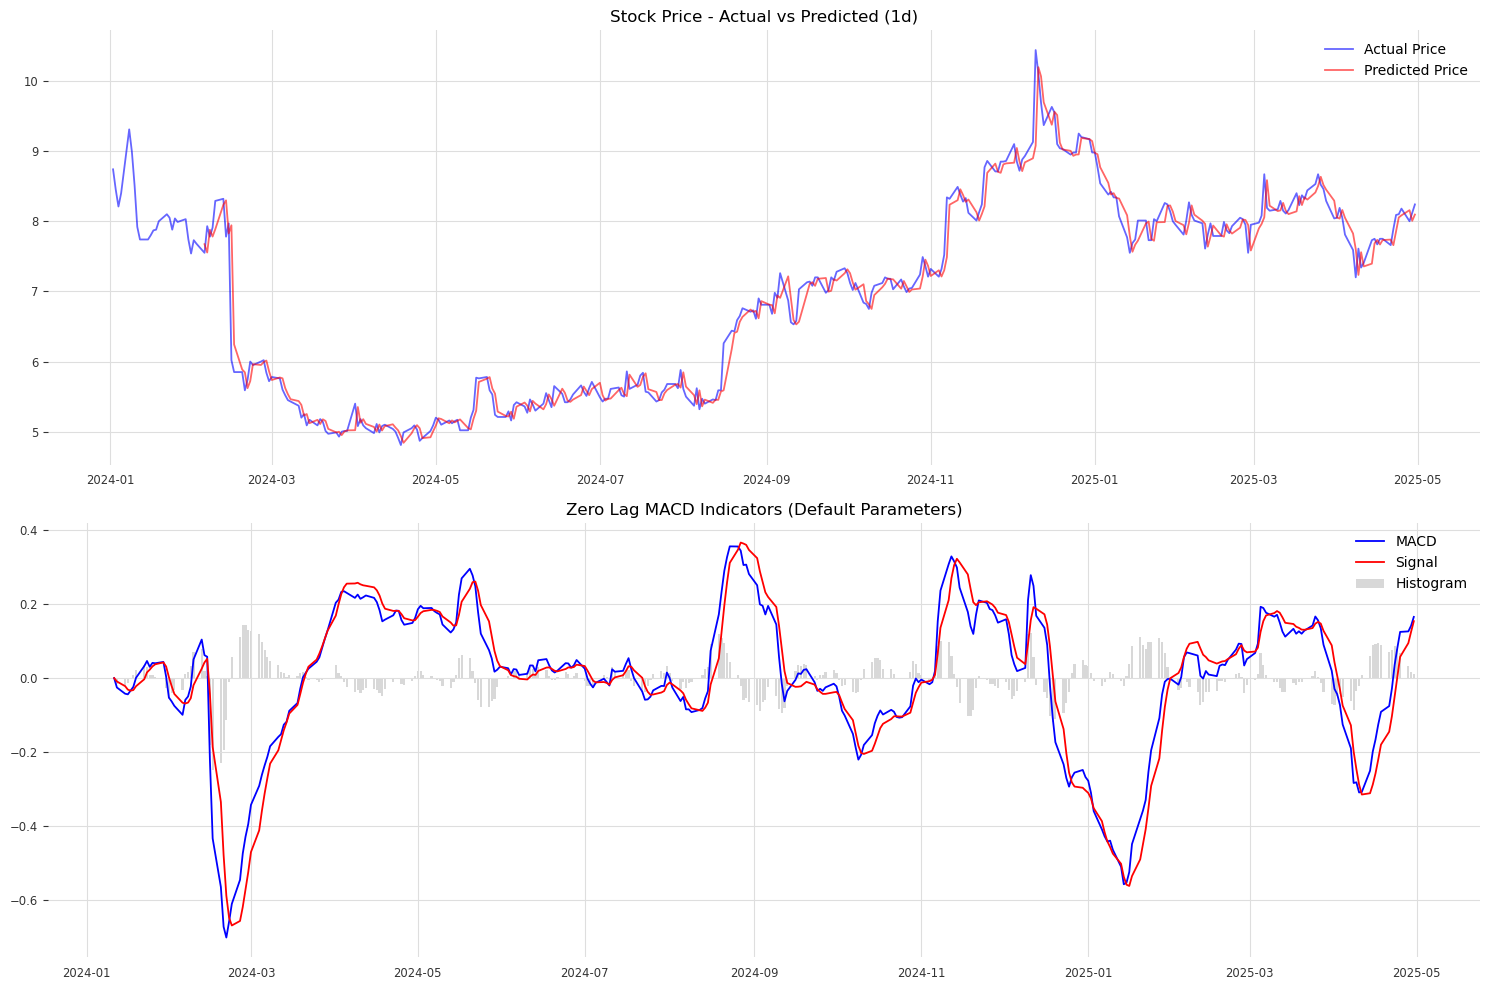

In [ ]:
import matplotlib.pyplot as plt

def scale_data_backtesting(data_dict):
    """Scale data for backtesting/prediction only"""
    target_scaler = MinMaxScaler().fit(data_dict['test_target'])
    covariate_scaler = MinMaxScaler().fit(data_dict['test_covariates'])
    
    scaled_data = {}
    
    # Handle training data (empty)
    scaled_data['train_target'] = pd.DataFrame(
        np.empty((0, 1)),  # Empty array with correct shape
        columns=['Close'],
        index=data_dict['train_target'].index
    )
    
    scaled_data['train_covariates'] = pd.DataFrame(
        np.empty((0, 4)),  # Empty array with correct shape for 4 features
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['train_covariates'].index
    )
    
    # Handle test data
    scaled_data['test_target'] = pd.DataFrame(
        target_scaler.transform(data_dict['test_target']),
        columns=['Close'],
        index=data_dict['test_target'].index
    )
    
    scaled_data['test_covariates'] = pd.DataFrame(
        covariate_scaler.transform(data_dict['test_covariates']),
        columns=['Open', 'High', 'Low', 'Volume'],
        index=data_dict['test_covariates'].index
    )
    
    return scaled_data, target_scaler

def create_ensemble_backtest_predictions(lr_results, lstm_results, gru_results, ts_data_backtest, target_scaler_backtest):
    """
    Create ensemble predictions from Linear Regression, LSTM, and GRU for backtesting
    """
    print("\n📈 Generating Ensemble Predictions...")
    
    # 1. Linear Regression predictions
    print("🔹 Running Linear Regression...")
    lr_backtest_pred = lr_results['model'].historical_forecasts(
        series=ts_data_backtest['test_y'],
        past_covariates=ts_data_backtest['test_x'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False
    )
    
    # 2. LSTM predictions
    print("🔹 Running LSTM...")
    lstm_backtest_pred = lstm_results['model'].historical_forecasts(
        series=ts_data_backtest['test_y'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False,
    )

    # 3. GRU predictions
    print("🔹 Running GRU...")
    gru_backtest_pred = gru_results['model'].historical_forecasts(
        series=ts_data_backtest['test_y'],
        start=0,
        forecast_horizon=1,
        stride=1,
        retrain=False,
    )
    
    print("🔄 Creating Ensemble from Individual Predictions...")
    
    # Inverse transform all predictions
    lr_pred_inverse = inverse_transform_series(lr_backtest_pred, target_scaler_backtest)
    lstm_pred_inverse = inverse_transform_series(lstm_backtest_pred, target_scaler_backtest)
    gru_pred_inverse = inverse_transform_series(gru_backtest_pred, target_scaler_backtest)
    
    # Find common time range
    all_preds = [lr_pred_inverse, lstm_pred_inverse, gru_pred_inverse]
    start_times = [pred.start_time() for pred in all_preds]
    end_times = [pred.end_time() for pred in all_preds]
    common_start = max(start_times)
    common_end = min(end_times)
    
    # Slice all predictions to common time range
    lr_aligned = lr_pred_inverse.slice(common_start, common_end)
    lstm_aligned = lstm_pred_inverse.slice(common_start, common_end)
    gru_aligned = gru_pred_inverse.slice(common_start, common_end)
    
    # Simple averaging (equal weights: 1/3 each)
    common_times = lr_aligned.time_index
    ensemble_values = (lr_aligned.values().flatten() + lstm_aligned.values().flatten() + gru_aligned.values().flatten()) / 3
    
    # Create ensemble TimeSeries
    ensemble_pred = TimeSeries.from_times_and_values(
        times=common_times,
        values=ensemble_values
    )
    
    print("🎯 Ensemble Created with Simple Averaging:")
    print(f"   📊 Linear Regression: 33.33%")
    print(f"   📊 LSTM: 33.33%")
    print(f"   📊 GRU: 33.33%")
    print(f"   📈 Total predictions: {len(ensemble_pred)}")
    
    return ensemble_pred

# Cell 2: Backtesting on New Data with Ensemble
# New parameters for backtesting
backtest_ticker = "AUPH"
start_date_backtest = "2024-01-01"
end_date_backtest = "2025-05-01"
interval_backtest = "1d"

print(f"🔬 Starting Ensemble Backtesting for {backtest_ticker}")
print(f"📅 Period: {start_date_backtest} to {end_date_backtest}")
print(f"📊 Interval: {interval_backtest}")
print("=" * 60)

# Fetch new data for backtesting
df_backtest = fetch_stock_data(backtest_ticker, start_date_backtest, end_date_backtest, interval_backtest)

# Create a DataFrame with actual prices for MACD calculation
actual_df = pd.DataFrame({
    'Close': df_backtest['Close'].values.flatten()
}, index=df_backtest.index)

# First, ensure index is timezone-naive by removing any timezone info
if actual_df.index.tz is not None:
    actual_df.index = actual_df.index.tz_localize(None)

# Apply the same time filtering as with predicted prices
if interval_backtest == "1d":
    # Only filter by business days
    actual_df = actual_df[actual_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    actual_df = actual_df[(actual_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (actual_df.index.time <= pd.to_datetime('20:00:00').time())]
    actual_df = actual_df[actual_df.index.weekday < 5]

# Apply lag for MACD calculation
def apply_lag(df, lag_periods=7):
    """Apply lag to the dataframe for MACD calculation"""
    lagged_df = df.copy()
    lagged_df['Close_Lag'] = df['Close'].shift(lag_periods)
    return lagged_df.dropna()  # Remove NaN values created by the shift

# Apply the lag of 7
actual_df = apply_lag(actual_df, lag_periods=7)

# Prepare data (using full dataset as test)
data_dict_backtest = {
    'train_target': df_backtest[['Close']].iloc[:0],  # Empty training set
    'test_target': df_backtest[['Close']],
    'train_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']].iloc[:0],
    'test_covariates': df_backtest[['Open', 'High', 'Low', 'Volume']]
}

# Scale data
scaled_data_backtest, target_scaler_backtest = scale_data_backtesting(data_dict_backtest)
    
# Create time series
ts_data_backtest = create_time_series(scaled_data_backtest, interval_backtest)

# ✅ CREATE ENSEMBLE PREDICTIONS (Linear Regression + LSTM + GRU)
backtest_pred = create_ensemble_backtest_predictions(
    lr_results, 
    lstm_results, 
    gru_results,
    ts_data_backtest, 
    target_scaler_backtest
)

# Convert ensemble predictions to the expected format
test_pred_backtest_results = backtest_pred  # Already inverse transformed in ensemble function

# Convert to DataFrame for indicator calculation
backtest_df = pd.DataFrame({
    'Close': test_pred_backtest_results.values().flatten()
}, index=test_pred_backtest_results.time_index)

if interval_backtest == "1d":
    # Only filter by business days
    backtest_df = backtest_df[backtest_df.index.weekday < 5]
else:  
    # For hourly data, keep your time filtering
    backtest_df = backtest_df[(backtest_df.index.time >= pd.to_datetime('13:30:00').time()) & 
                         (backtest_df.index.time <= pd.to_datetime('20:00:00').time())]
    backtest_df = backtest_df[backtest_df.index.weekday < 5]

print(f"\n✅ Ensemble Complete!")
print(f"📊 Actual data points: {len(actual_df)}")
print(f"📊 Ensemble predictions: {len(backtest_df)}")
print(f"📊 Common data points: {len(actual_df.index.intersection(backtest_df.index))}")

# Calculate indicators
macd_results = calculate_zero_lag_macd(actual_df)

# Show basic charts - actual vs ensemble predictions and MACD
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_backtest.index, df_backtest['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(backtest_df.index, backtest_df['Close'], label='Ensemble Prediction (LR+LSTM+GRU)', color='purple', alpha=0.8, linewidth=2)
plt.title(f'{backtest_ticker} Stock Price - Actual vs Ensemble Prediction ({interval_backtest})')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(macd_results.index, macd_results['ZL_MACD'], label='MACD', color='blue')
plt.plot(macd_results.index, macd_results['Signal'], label='Signal', color='red')
plt.bar(macd_results.index, macd_results['Histogram'], label='Histogram', color='grey', alpha=0.3)
plt.title('Zero Lag MACD Indicators (Default Parameters)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🎯 Ready for MACD Strategy Backtesting with Ensemble Predictions!")
print(f"📋 Use 'actual_df' for signals and 'backtest_df' for prediction validation")

### Execution of the Ensemble Machine Learning Enhanced Trading Strategies

This cell executes the final step of the ensemble machine learning enhanced Zero-Lag MACD backtesting framework. It defines a list of trading strategies, sets the MACD parameter optimization range, and runs the `run_optimized_strategies` function to find the best MACD parameters for each strategy using both actual and predicted (ensemble) prices. The cell then prints a summary of the optimal parameters for each strategy and displays a performance comparison table, allowing

Step 9: Run the following cells to execute the Zero-Lag MACD enhanced trading strategies.


Optimizing parameters for Buy Above Sell Above...
Best parameters found:
Fast Length: 5
Slow Length: 29
Signal Length: 30
ROI: 67.39%

Strategy with Prediction Validation: Buy Above Sell Above

=== Detailed Trade Log with Prediction Validation ===
Initial Balance: $10,000.00

Date                 Action   Status     Shares     Price      Pred Next (Δ%) @ Time  Cost/Profit  Balance     
------------------------------------------------------------------------------------------------------------------------
2024-04-10 00:00     SELL     REJECTED   0          $4.99      $5.02 ↑0.54% @ 01:00   $0.00        $10000.00    (pred ≥ current)
2024-04-12 00:00     BUY      CONFIRMED  1941       $5.10      $5.11 ↑0.11% @ 01:00   $9899.10     $1.91       
2024-04-15 00:00     SELL     REJECTED   0          $5.04      $5.06 ↑0.38% @ 01:00   $0.00        $1.91        (pred ≥ current)
2024-05-01 00:00     BUY      REJECTED   0          $5.20      $5.19 ↓0.16% @ 01:00   $0.00        $1.91        (pred ≤


Optimizing parameters for Buy Below Sell Above...
Best parameters found:
Fast Length: 21
Slow Length: 30
Signal Length: 30
ROI: 68.56%

Strategy with Prediction Validation: Buy Below Sell Above

=== Detailed Trade Log with Prediction Validation ===
Initial Balance: $10,000.00

Date                 Action   Status     Shares     Price      Pred Next (Δ%) @ Time  Cost/Profit  Balance     
------------------------------------------------------------------------------------------------------------------------
2024-03-05 00:00     BUY      CONFIRMED  1768       $5.60      $5.62 ↑0.39% @ 01:00   $9900.80     $0.19       
2024-04-25 00:00     SELL     REJECTED   0          $4.87      $4.91 ↑0.79% @ 01:00   $0.00        $0.19        (pred ≥ current)
2024-05-22 00:00     SELL     REJECTED   0          $5.53      $5.54 ↑0.23% @ 01:00   $0.00        $0.19        (pred ≥ current)
2024-07-19 00:00     SELL     REJECTED   0          $5.56      $5.57 ↑0.11% @ 01:00   $0.00        $0.19        (pred 


Optimizing parameters for Buy Above Sell Below...
Best parameters found:
Fast Length: 5
Slow Length: 6
Signal Length: 12
ROI: 76.04%

Strategy with Prediction Validation: Buy Above Sell Below

=== Detailed Trade Log with Prediction Validation ===
Initial Balance: $10,000.00

Date                 Action   Status     Shares     Price      Pred Next (Δ%) @ Time  Cost/Profit  Balance     
------------------------------------------------------------------------------------------------------------------------
2024-02-13 00:00     SELL     REJECTED   0          $7.78      $7.83 ↑0.59% @ 01:00   $0.00        $10000.00    (pred ≥ current)
2024-03-15 00:00     BUY      REJECTED   0          $5.17      $5.17 ↓0.02% @ 01:00   $0.00        $10000.00    (pred ≤ current)
2024-03-27 00:00     BUY      CONFIRMED  1980       $5.00      $5.00 ↑0.05% @ 01:00   $9900.00     $1.00       
2024-04-11 00:00     BUY      REJECTED   0          $5.08      $5.08 ↓0.02% @ 01:00   $0.00        $1.00        (pred ≤ 


Optimizing parameters for Buy Below Sell Below...
Best parameters found:
Fast Length: 21
Slow Length: 30
Signal Length: 5
ROI: 72.27%

Strategy with Prediction Validation: Buy Below Sell Below

=== Detailed Trade Log with Prediction Validation ===
Initial Balance: $10,000.00

Date                 Action   Status     Shares     Price      Pred Next (Δ%) @ Time  Cost/Profit  Balance     
------------------------------------------------------------------------------------------------------------------------
2024-02-06 00:00     BUY      REJECTED   0          $7.93      $7.88 ↓0.64% @ 01:00   $0.00        $10000.00    (pred ≤ current)
2024-02-22 00:00     BUY      REJECTED   0          $6.00      $5.96 ↓0.62% @ 01:00   $0.00        $10000.00    (pred ≤ current)
2024-03-14 00:00     SELL     REJECTED   0          $5.09      $5.12 ↑0.61% @ 01:00   $0.00        $10000.00    (pred ≥ current)
2024-03-15 00:00     BUY      REJECTED   0          $5.17      $5.17 ↓0.02% @ 01:00   $0.00        $10


Optimizing parameters for Histogram Trend Reversal...
Best parameters found:
Fast Length: 5
Slow Length: 15
Signal Length: 23
ROI: 43.20%

Strategy with Prediction Validation: Histogram Trend Reversal

=== Detailed Trade Log with Prediction Validation ===
Initial Balance: $10,000.00

Date                 Action   Status     Shares     Price      Pred Next (Δ%) @ Time  Cost/Profit  Balance     
------------------------------------------------------------------------------------------------------------------------
2024-02-06 00:00     BUY      REJECTED   0          $7.93      $7.88 ↓0.64% @ 01:00   $0.00        $10000.00    (pred ≤ current)
2024-02-13 00:00     SELL     REJECTED   0          $7.78      $7.83 ↑0.59% @ 01:00   $0.00        $10000.00    (pred ≥ current)
2024-02-19 00:00     BUY      REJECTED   0          $5.85      $5.85 ↓0.07% @ 01:00   $0.00        $10000.00    (pred ≤ current)
2024-02-28 00:00     SELL     REJECTED   0          $5.84      $5.86 ↑0.36% @ 01:00   $0.00   


=== Strategy Comparison with Optimized Parameters ===
                          Fast Length  Slow Length  Signal Length  ROI (%)  \
Strategy                                                                     
Buy Above Sell Above                5           29             30    67.39   
Buy Below Sell Above               21           30             30    68.56   
Buy Above Sell Below                5            6             12    76.04   
Buy Below Sell Below               21           30              5    72.27   
Histogram Trend Reversal            5           15             23    43.20   

                          Signal Count  Confirmed Signals  Executed Trades  \
Strategy                                                                     
Buy Above Sell Above                31                  2                2   
Buy Below Sell Above                12                  2                2   
Buy Above Sell Below                40                  2                2   
Buy Belo

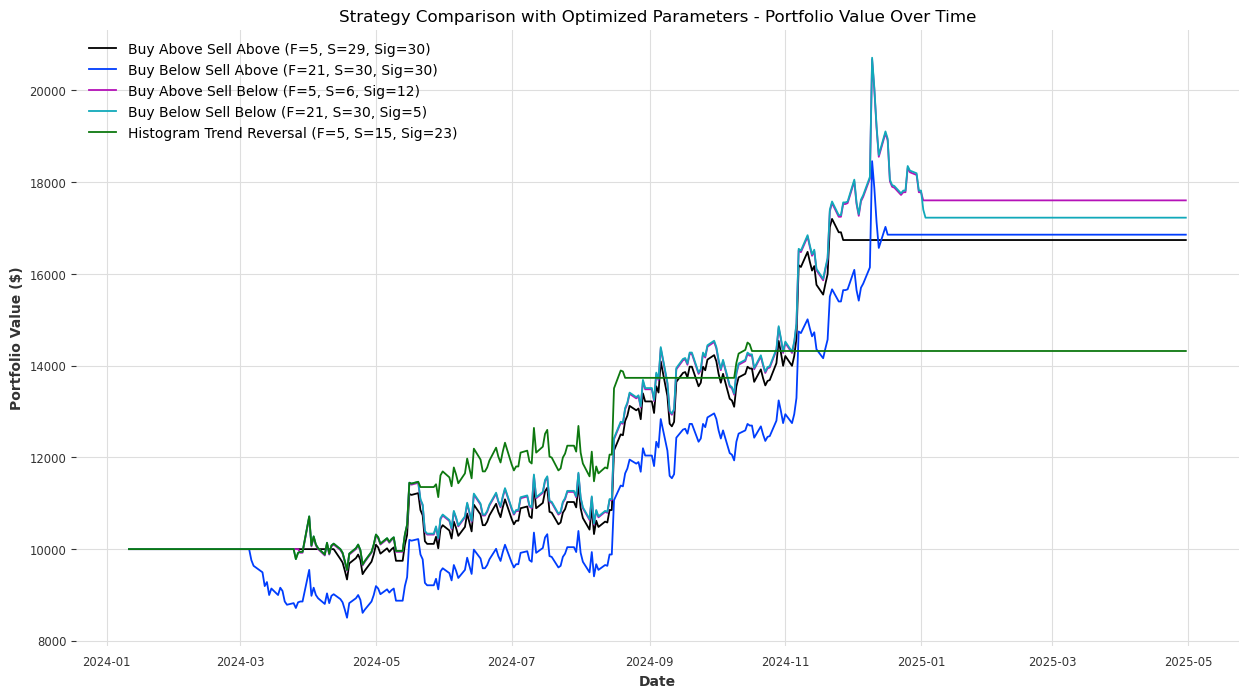


Summary of Best Parameters:
Buy Above Sell Above: Fast=5, Slow=29, Signal=30
Buy Below Sell Above: Fast=21, Slow=30, Signal=30
Buy Above Sell Below: Fast=5, Slow=6, Signal=12
Buy Below Sell Below: Fast=21, Slow=30, Signal=5
Histogram Trend Reversal: Fast=5, Slow=15, Signal=23

Strategy Performance Comparison:
                          Fast Length  Slow Length  Signal Length  ROI (%)  \
Strategy                                                                     
Buy Above Sell Below                5            6             12    76.04   
Buy Below Sell Below               21           30              5    72.27   
Buy Below Sell Above               21           30             30    68.56   
Buy Above Sell Above                5           29             30    67.39   
Histogram Trend Reversal            5           15             23    43.20   

                          Signal Count  Confirmed Signals  Executed Trades  \
Strategy                                                       

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define strategies to test
strategies = [
    "Buy Above Sell Above",
    "Buy Below Sell Above",
    "Buy Above Sell Below", 
    "Buy Below Sell Below",
    "Histogram Trend Reversal"
]

# Run optimization with a suitable parameter range
# Use a smaller range for faster results when testing (e.g. 5-15)
# Use the full range (5-30) for better results but this will take longer
param_range = (5, 30)  # Adjust based on time constraints

# Run the optimization
optimized_results = run_optimized_strategies(actual_df, backtest_df, strategies, param_range=param_range)

# Display summary of best parameters found for each strategy
print("\nSummary of Best Parameters:")
for strategy, params in optimized_results['parameters'].items():
    print(f"{strategy}: Fast={params['fast_length']}, Slow={params['slow_length']}, Signal={params['signal_length']}")

# Display the metrics comparison table again
if not optimized_results['metrics'].empty:
    print("\nStrategy Performance Comparison:")
    print(optimized_results['metrics'].set_index('Strategy').sort_values('ROI (%)', ascending=False).round(2))

## Zero-Lag MACD Backtesting

These steps cover the development of the Zero-Lag MACD for backtesting trading strategies in trading scenarios without using any integration of machine learning models.

This cell provides core technical analysis utilities for the backtesting framework. It includes functions to fetch historical stock data from Yahoo Finance, calculate the Zero-Lag MACD indicator (with both EMA and SMA options), and generate trading signals for various MACD-based strategies. The `generate_signals` function supports multiple strategy types, including crossover and histogram trend reversal logic, enabling flexible signal generation for systematic trading and backtesting.

**Please run all the following cells**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

def fetch_stock_data(ticker, start_date, end_date, interval):
    """Fetch stock data from Yahoo Finance"""
    df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    
    freq_map = {"15m": "15T", "30m": "30T", "1h": "H", "1d": "B"}
    df.index = pd.DatetimeIndex(df.index)
    df = df.asfreq(freq_map.get(interval, "B"))
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    return df.fillna(method='ffill')

def calculate_zero_lag_macd(data, fast_length=12, slow_length=26, signal_length=9, 
                            use_ema=True, use_old_algo=False, macd_ema_length=1):
    """
    Calculate Zero Lag MACD indicator
    
    Parameters:
        data: DataFrame with Close prices
        fast_length: Fast EMA period
        slow_length: Slow EMA period
        signal_length: Signal line period
        use_ema: Use EMA (True) or SMA (False)
        use_old_algo: Use traditional signal calculation (True) or zero lag (False)
        macd_ema_length: MACD EMA smoothing period
    """
    # Zero Lag EMA Calculation
    def zero_lag(series, length, use_ema):
        if use_ema:
            ma1 = series.ewm(span=length, adjust=False).mean()
            ma2 = ma1.ewm(span=length, adjust=False).mean()
        else:
            ma1 = series.rolling(window=length).mean()
            ma2 = ma1.rolling(window=length).mean()
        return 2 * ma1 - ma2
    
    # Calculate Zero Lag MACD components
    fast_zlema = zero_lag(data['Close'], fast_length, use_ema)
    slow_zlema = zero_lag(data['Close'], slow_length, use_ema)
    zl_macd = fast_zlema - slow_zlema
    
    # Signal Line
    if use_old_algo:
        signal_line = zl_macd.rolling(window=signal_length).mean()
    else:
        ema_sig1 = zl_macd.ewm(span=signal_length, adjust=False).mean()
        ema_sig2 = ema_sig1.ewm(span=signal_length, adjust=False).mean()
        signal_line = 2 * ema_sig1 - ema_sig2
    
    # Histogram and MACD EMA
    histogram = zl_macd - signal_line
    macd_ema = zl_macd.ewm(span=macd_ema_length, adjust=False).mean()
    
    return pd.DataFrame({
        'ZL_MACD': zl_macd,
        'Signal': signal_line,
        'Histogram': histogram,
        'MACD_EMA': macd_ema
    })

def crossover(series1, series2):
    """Detect crossover points between two series"""
    return (series1 > series2) & (series1.shift(1) < series2.shift(1))

def crossunder(series1, series2):
    """Detect crossunder points between two series"""
    return (series1 < series2) & (series1.shift(1) > series2.shift(1))

def generate_signals(indicators, strategy_type, macd_col='ZL_MACD'):
    """Generate trading signals based on strategy type"""
    signals = pd.Series(0, index=indicators.index)
    
    if strategy_type == "Buy Above Sell Above":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = 1
        signals[crossunder(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = -1
    
    elif strategy_type == "Buy Below Sell Above":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = 1
        signals[crossunder(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = -1
    
    elif strategy_type == "Buy Above Sell Below":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] > 0)] = 1
        signals[crossunder(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = -1
    
    elif strategy_type == "Buy Below Sell Below":
        signals[crossover(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = 1
        signals[crossunder(indicators[macd_col], indicators['Signal']) & 
               (indicators[macd_col] < 0)] = -1
    
    elif strategy_type == "Histogram Trend Reversal":
        histogram = indicators['Histogram']
        histogram_diff = histogram.diff()
        
        # Buy: Histogram was negative & decreasing, now increasing
        signals[(histogram.shift(1) < 0) & 
               (histogram_diff.shift(1) < 0) & 
               (histogram_diff > 0)] = 1
        
        # Sell: Histogram was positive & increasing, now decreasing
        signals[(histogram.shift(1) > 0) & 
               (histogram_diff.shift(1) > 0) & 
               (histogram_diff < 0)] = -1

    return pd.DataFrame({'Signal': signals}, index=indicators.index)

This cell implements the core backtesting and visualization functions for the Zero-Lag MACD trading strategy. The `backtest_strategy` function simulates trading based on generated MACD signals, tracking portfolio value, trades, and performance metrics such as ROI, profit factor, and win rate. The `plot_strategy_results` function visualizes price, buy/sell trades, and MACD indicator components using Plotly. The `print_detailed_trade_summary` function outputs a detailed trade log with profit/loss and running balance for each trade, providing a comprehensive evaluation of the strategy's effectiveness.

In [ ]:
def backtest_strategy(data, signals, initial_cash=10000, transaction_fee=0.01):
    """
    Backtest a trading strategy using MACD signals
    
    Parameters:
        data: DataFrame with price data
        signals: DataFrame with trading signals
        initial_cash: Initial investment amount
        transaction_fee: Transaction fee as percentage
        stop_loss_pct: Optional stop loss percentage
        take_profit_pct: Optional take profit percentage
        
    Returns:
        Dict with backtest results
    """
    cash = initial_cash
    shares = 0
    total_trades = 0
    buy_prices = []
    sell_prices = []
    trade_log = []
    equity_curve = []
    entry_price = 0
    
    for i in range(len(data)):
        current_date = data.index[i]
        current_price = data['Close'].iloc[i]
        signal = signals['Signal'].iloc[i]
        
        # Calculate current portfolio value
        current_value = cash + (shares * current_price)
        equity_curve.append({
            'date': current_date,
            'value': current_value
        })
        
        # Buy logic
        if signal == 1 and cash > 0:
            max_investment = cash / (1 + transaction_fee)
            shares_to_buy = int(max_investment // current_price)
            
            if shares_to_buy > 0:
                purchase_cost = shares_to_buy * current_price
                fee_cost = purchase_cost * transaction_fee
                total_cost = purchase_cost + fee_cost
                
                if total_cost <= cash:
                    cash -= total_cost
                    shares += shares_to_buy
                    entry_price = current_price  # Set entry price for stop loss/take profit
                    buy_prices.append(current_price)
                    total_trades += 1
                    trade_log.append({
                        'type': 'BUY',
                        'date': str(current_date),
                        'price': current_price,
                        'shares': shares_to_buy,
                        'fee': fee_cost,
                        'cash_left': cash
                    })
        
        # Sell logic
        elif signal == -1 and shares > 0:
            sell_value = shares * current_price
            fee_cost = sell_value * transaction_fee
            net_sell_value = sell_value - fee_cost
            
            cash += net_sell_value
            sell_prices.append(current_price)
            trade_log.append({
                'type': 'SELL',
                'date': str(current_date),
                'price': current_price,
                'shares': shares,
                'fee': fee_cost,
                'cash_left': cash
            })
            shares = 0
            total_trades += 1
    
    # Add the final point to the equity curve
    if len(data) > 0:
        final_value = cash + (shares * data['Close'].iloc[-1])
        equity_curve.append({
            'date': data.index[-1],
            'value': final_value
        })
    
    # Calculate returns and metrics
    final_value = cash + (shares * data['Close'].iloc[-1] if len(data) > 0 else 0)
    roi = ((final_value - initial_cash) / initial_cash) * 100
    
    # Calculate profit factor (sum of profits / sum of losses)
    profit_trades = [trade for trade in trade_log if trade['type'] == 'SELL' and trade['price'] > buy_prices[trade_log.index(trade) // 2]]
    loss_trades = [trade for trade in trade_log if trade['type'] == 'SELL' and trade['price'] <= buy_prices[trade_log.index(trade) // 2]]
    
    total_profit = sum([(t['price'] * t['shares']) - (buy_prices[trade_log.index(t) // 2] * t['shares']) for t in profit_trades]) if profit_trades else 0
    total_loss = sum([(buy_prices[trade_log.index(t) // 2] * t['shares']) - (t['price'] * t['shares']) for t in loss_trades]) if loss_trades else 0
    profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
    
    # Calculate other metrics
    winning_trades = len(profit_trades)
    losing_trades = len(loss_trades)
    win_rate = (winning_trades / (winning_trades + losing_trades)) * 100 if (winning_trades + losing_trades) > 0 else 0
    
    return {
        'final_value': final_value,
        'total_trades': total_trades,
        'roi': roi,
        'profit_factor': profit_factor,
        'win_rate': win_rate,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'buy_and_hold_return': ((data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]) * 100,
        'trade_log': trade_log,
        'equity_curve': pd.DataFrame(equity_curve).set_index('date')
    }

def plot_strategy_results(data, signals, macd_results, backtest_results, strategy_name):
    """Plot price, trades and Zero Lag MACD indicators using Plotly"""
    
    # Create figure with multiple subplots
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.03,
                        row_heights=[0.7, 0.3])

    # Add price line
    fig.add_trace(
        go.Scatter(x=data.index, y=data['Close'],
                  name='Price',
                  line=dict(color='blue', width=1)),
        row=1, col=1
    )

    # Add buy signals
    buy_signals = [trade for trade in backtest_results['trade_log'] if trade['type'] == 'BUY']
    if buy_signals:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in buy_signals],
                y=[trade['price'] for trade in buy_signals],
                mode='markers',
                name='Buy',
                marker=dict(symbol='triangle-up', size=10, color='green'),
                hovertemplate='Buy: %{y:.2f}<br>Date: %{x}<extra></extra>'
            ),
            row=1, col=1
        )

    # Add sell signals
    sell_signals = [trade for trade in backtest_results['trade_log'] if trade['type'] == 'SELL' 
                    or trade['type'] == 'STOP_LOSS' or trade['type'] == 'TAKE_PROFIT']
    if sell_signals:
        fig.add_trace(
            go.Scatter(
                x=[pd.to_datetime(trade['date']) for trade in sell_signals],
                y=[trade['price'] for trade in sell_signals],
                mode='markers',
                name='Sell',
                marker=dict(symbol='triangle-down', size=10, color='red'),
                hovertemplate='Sell: %{y:.2f}<br>Date: %{x}<extra></extra>'
            ),
            row=1, col=1
        )

    # Add MACD line
    fig.add_trace(
        go.Scatter(x=macd_results.index, y=macd_results['ZL_MACD'],
                  name='MACD',
                  line=dict(color='blue', width=1)),
        row=2, col=1
    )

    # Add Signal line
    fig.add_trace(
        go.Scatter(x=macd_results.index, y=macd_results['Signal'],
                  name='Signal',
                  line=dict(color='orange', width=1)),
        row=2, col=1
    )

    # Add Histogram
    fig.add_trace(
        go.Bar(x=macd_results.index, y=macd_results['Histogram'],
               name='Histogram',
               marker_color='gray',
               opacity=0.3),
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title=f'Zero Lag MACD Strategy: {strategy_name}<br>' + 
              f'ROI: {backtest_results["roi"]:.2f}%, Trades: {backtest_results["total_trades"]}, ' +
              f'Win Rate: {backtest_results["win_rate"]:.1f}%',
        height=800,
        showlegend=True,
        xaxis_rangeslider_visible=False
    )

    # Update y-axes labels
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="MACD", row=2, col=1)

    return fig

def print_detailed_trade_summary(trade_log, initial_cash, ticker):
    """Print detailed trade summary"""
    running_balance = initial_cash
    total_profit = 0
    current_position = None
    
    print(f"\n=== Detailed Trade Log for {ticker} ===")
    print(f"Initial Balance: ${initial_cash:,.2f}")
    print("\n{:<20} {:<12} {:<10} {:<10} {:<12} {:<12}".format(
        'Date', 'Action', 'Shares', 'Price', 'Cost/Profit', 'Balance'))
    print("-" * 80)
    
    for trade in trade_log:
        date = pd.to_datetime(trade['date']).strftime('%Y-%m-%d %H:%M')
        current_price = trade['price']
        
        if trade['type'] in ['BUY']:
            cost = current_price * trade['shares']
            running_balance -= (cost + trade['fee'])
            print("{:<20} {:<12} {:<10d} ${:<9.2f} ${:<11.2f} ${:<11.2f}".format(
                date, 'BUY', trade['shares'], current_price, cost, running_balance))
            current_position = trade
            
        elif trade['type'] in ['SELL', 'STOP_LOSS', 'TAKE_PROFIT']:
            trade_type = trade['type']
            proceeds = current_price * trade['shares']
            if current_position:
                entry_cost = current_position['price'] * trade['shares']
                profit = proceeds - entry_cost - trade['fee']
                total_profit += profit
            else:
                profit = 0
                
            running_balance += (proceeds - trade['fee'])
            print("{:<20} {:<12} {:<10d} ${:<9.2f} ${:<11.2f} ${:<11.2f}".format(
                date, trade_type, trade['shares'], current_price, profit, running_balance))
            print("-" * 80)
    
    print(f"\nFinal Balance: ${running_balance:,.2f}")
    print(f"Total Profit/Loss: ${total_profit:,.2f}")
    print(f"Return on Investment: {((running_balance - initial_cash) / initial_cash * 100):.2f}%")

This cell implements parameter optimization and evaluation for Zero-Lag MACD trading strategies. The `optimize_zero_lag_macd` function systematically searches for the best MACD parameters (fast, slow, and signal lengths) to maximize strategy ROI, running a backtest for each parameter combination and collecting performance metrics. The `run_optimized_strategies` function automates this process for multiple strategy types, summarizes the optimal parameters and results, prints detailed trade logs, and visualizes both individual and comparative strategy performance. This enables robust selection and benchmarking of MACD-based trading strategies.

In [ ]:
def optimize_zero_lag_macd(data, strategy_type, param_range=(5, 30), transaction_fee=0.01):
    """
    Optimize Zero Lag MACD parameters for a given strategy
    
    Parameters:
        data: DataFrame with price data
        strategy_type: Type of strategy to test
        param_range: Tuple with min and max parameter values to test
        transaction_fee: Transaction fee percentage
        stop_loss_pct: Optional stop loss percentage
        take_profit_pct: Optional take profit percentage
        
    Returns:
        Dict with best parameters and results
    """
    best_roi = -float('inf')
    best_params = None
    best_results = None
    results_list = []
    
    # Create parameter combinations
    min_param, max_param = param_range
    for fast_length in range(min_param, max_param + 1):
        for slow_length in range(fast_length + 1, max_param + 1):  # Slow must be greater than fast
            for signal_length in range(min_param, max_param + 1):
                # Calculate indicators with current parameters
                macd_indicators = calculate_zero_lag_macd(
                    data, 
                    fast_length=fast_length, 
                    slow_length=slow_length, 
                    signal_length=signal_length
                )
                
                # Generate signals based on strategy type
                signals = generate_signals(macd_indicators, strategy_type, macd_col='ZL_MACD')
                
                # Run backtest with current parameters
                results = backtest_strategy(
                    data,
                    signals,
                    initial_cash=10000,
                    transaction_fee=transaction_fee,
                )
                
                # Store results for comparison
                param_result = {
                    'fast_length': fast_length,
                    'slow_length': slow_length,
                    'signal_length': signal_length,
                    'roi': results['roi'],
                    'total_trades': results['total_trades'],
                    'win_rate': results['win_rate'],
                    'profit_factor': results['profit_factor'],
                    'final_value': results['final_value']
                }
                results_list.append(param_result)
                
                # Update best parameters if current ROI is better and has trades
                if results['roi'] > best_roi and results['total_trades'] > 0:
                    best_roi = results['roi']
                    best_params = {
                        'fast_length': fast_length,
                        'slow_length': slow_length,
                        'signal_length': signal_length
                    }
                    best_results = results
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results_list)
    if not results_df.empty:
        results_df = results_df.sort_values('roi', ascending=False)
    
    return {
        'best_params': best_params,
        'best_results': best_results,
        'all_results': results_df
    }

def run_optimized_strategies(data, strategies, param_range=(5, 20), 
                             transaction_fee=0.01):
    """
    Run strategies with optimized parameters
    
    Parameters:
        data: DataFrame with price data
        strategies: List of strategies to test
        param_range: Range of parameters to test (min, max)
        transaction_fee: Transaction fee percentage
        stop_loss_pct: Optional stop loss percentage 
        take_profit_pct: Optional take profit percentage
        
    Returns:
        Dict with optimized results for each strategy
    """
    results = {}
    strategy_metrics = pd.DataFrame()
    optimized_parameters = {}
    
    for strategy in strategies:
        print(f"\n{'='*50}")
        print(f"Optimizing parameters for {strategy}...")
        print(f"{'='*50}")
        
        # Run parameter optimization
        opt_results = optimize_zero_lag_macd(
            data, 
            strategy, 
            param_range=param_range,
            transaction_fee=transaction_fee,
        )
        
        if opt_results['best_params'] is None:
            print(f"No valid parameter combination found for {strategy}")
            continue
            
        best_params = opt_results['best_params']
        optimized_parameters[strategy] = best_params
        
        print(f"Best parameters found:")
        print(f"Fast Length: {best_params['fast_length']}")
        print(f"Slow Length: {best_params['slow_length']}")
        print(f"Signal Length: {best_params['signal_length']}")
        print(f"ROI: {opt_results['best_results']['roi']:.2f}%")
        
        # Calculate indicators with best parameters
        macd_results = calculate_zero_lag_macd(
            data,
            fast_length=best_params['fast_length'],
            slow_length=best_params['slow_length'],
            signal_length=best_params['signal_length']
        )
        
        # Generate signals based on best parameters
        signals = generate_signals(macd_results, strategy, macd_col='ZL_MACD')
        
        # Run backtest with best parameters
        results[strategy] = opt_results['best_results']
        
        # Store metrics for comparison
        strategy_metrics = pd.concat([strategy_metrics, pd.DataFrame({
            'Strategy': [strategy],
            'Fast Length': [best_params['fast_length']],
            'Slow Length': [best_params['slow_length']],
            'Signal Length': [best_params['signal_length']],
            'ROI (%)': [results[strategy]['roi']],
            'Total Trades': [results[strategy]['total_trades']],
            'Win Rate (%)': [results[strategy]['win_rate']],
            'Profit Factor': [results[strategy]['profit_factor']],
            'Final Value ($)': [results[strategy]['final_value']]
        })])
        
        # Print detailed trade log
        print(f"\n{'='*50}")
        print(f"Zero Lag MACD Strategy: {strategy}")
        print(f"{'='*50}")
        
        # Print trade details
        print_detailed_trade_summary(results[strategy]['trade_log'], initial_cash=10000, ticker=data['Close'].name if hasattr(data['Close'], 'name') else "")
        
        # Plot results
        fig = plot_strategy_results(
            data, 
            signals, 
            macd_results, 
            results[strategy], 
            f"{strategy} (Fast={best_params['fast_length']}, Slow={best_params['slow_length']}, Signal={best_params['signal_length']})"
        )
        fig.show()
    
    # Display comparison table
    if not strategy_metrics.empty:
        print("\n=== Strategy Comparison with Optimized Parameters ===")
        print(strategy_metrics.set_index('Strategy').round(2))
        
        # Plot comparison of equity curves
        plt.figure(figsize=(15, 8))
        for strategy in results:
            plt.plot(
                results[strategy]['equity_curve'].index, 
                results[strategy]['equity_curve']['value'], 
                label=f"{strategy} (F={optimized_parameters[strategy]['fast_length']}, S={optimized_parameters[strategy]['slow_length']}, Sig={optimized_parameters[strategy]['signal_length']})"
            )
        
        plt.title('Strategy Comparison with Optimized Parameters - Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return {
        'results': results,
        'metrics': strategy_metrics,
        'parameters': optimized_parameters
    }

This cell demonstrates a complete workflow for backtesting and optimizing Zero-Lag MACD trading strategies on historical stock data. It fetches price data for a specified ticker and period, defines a set of MACD-based trading strategies, and runs parameter optimization to find the best MACD settings (fast, slow, and signal lengths) for each strategy. After optimization, it prints a summary of the best parameters for each strategy, compares the optimized strategy returns to a simple buy-and-hold approach, and displays a table comparing the performance metrics (ROI, trades, win rate, etc.) of all strategies. 
This enables systematic evaluation and selection of the most effective MACD trading strategy for the chosen stock and timeframe.

In [ ]:
# Define ticker and time period
ticker = "TSLA"
start_date = "2024-10-01"
end_date = "2025-03-01"
interval = "1h"  # "1d", "1h", etc.

# Fetch stock data
df = fetch_stock_data(ticker, start_date, end_date, interval)

# Define strategies to test
strategies = [
    "Buy Above Sell Above",
    "Buy Below Sell Above",
    "Buy Above Sell Below", 
    "Buy Below Sell Below",
    "Histogram Trend Reversal"
]

# Run optimization with parameter range
optimized_results = run_optimized_strategies(
    df, 
    strategies, 
    param_range=(5, 30),
    transaction_fee=0.01,  
)

# Display summary of best parameters found for each strategy
print("\nSummary of Best Parameters:")
for strategy, params in optimized_results['parameters'].items():
    print(f"{strategy}: Fast={params['fast_length']}, Slow={params['slow_length']}, Signal={params['signal_length']}")

# Compare to buy and hold strategy
buy_and_hold_return = ((df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]) * 100
print(f"\nBuy and Hold Return: {buy_and_hold_return:.2f}%")

# Display the metrics comparison table again
if not optimized_results['metrics'].empty:
    print("\nStrategy Performance Comparison:")
    print(optimized_results['metrics'].set_index('Strategy').sort_values('ROI (%)', ascending=False).round(2))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\OMEN\AppData\Local\Temp\ipykernel_16368\1822169631.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='ffill')



Optimizing parameters for Buy Above Sell Above...
Best parameters found:
Fast Length: 9
Slow Length: 30
Signal Length: 5
ROI: 46.96%

Zero Lag MACD Strategy: Buy Above Sell Above

=== Detailed Trade Log for Close ===
Initial Balance: $10,000.00

Date                 Action       Shares     Price      Cost/Profit  Balance     
--------------------------------------------------------------------------------
2024-10-02 08:30     BUY          38         $258.01    $9804.38     $185.82     
2024-10-04 05:30     SELL         38         $240.70    $-666.93     $9323.27    
--------------------------------------------------------------------------------
2024-10-04 13:30     BUY          37         $247.21    $9146.77     $167.35     
2024-10-04 17:30     SELL         37         $249.18    $63.67       $9377.79    
--------------------------------------------------------------------------------
2024-10-05 07:30     BUY          37         $249.98    $9249.26     $119.28     
2024-10-08 16:30  


Optimizing parameters for Buy Below Sell Above...


KeyboardInterrupt: 